# Statistical analysis

## Setup

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
import seaborn as sns

from scipy import stats
import math

from collections import Counter

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)




In [3]:
experiments = pd.read_csv('../evaluation/resources/2020/all_experiments.csv')  
experiments = experiments.fillna('-')
experiments.subgroup = experiments.subgroup.apply(lambda row: 'none' if row == 'ignore' else row)
experiments.gr = experiments.apply(lambda df: '_'.join([df.group, df.subgroup]) if (df.group != '-' and df.subgroup != '-') else df.group, axis = 1)
experiments['gr'] = experiments.apply(lambda df: '_'.join([df.group, df.subgroup]),axis = 1)
experiments = experiments.drop('util', axis=1)

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


### effect size methods

In [4]:
def omega_squared(ms_effect, ms_error, df_effect, ss_total, roundd=True):
    wsq = (df_effect * (ms_effect - ms_error)) / (ss_total - ms_error)
    if roundd:
        return round(wsq,5)
    return wsq
    

In [5]:
def omega_squared_partial(ms_effect, ms_error, df_effect, total_observations, roundd=True):
    wsqp = (df_effect * (ms_effect - ms_error)) / (df_effect * ms_effect + (total_observations - df_effect) * ms_error)
    if roundd:
        return round(wsqp,5)
    return wsqp

In [6]:
def eta_squared(ss_effect, ss_total, roundd=True):
    if roundd:
        return round(ss_effect/ss_total,5)
    else:
        return ss_effect/ss_total

In [7]:
def eta_squared_partial(ss_effect, ss_error, roundd=True):
    if roundd:
        return round(ss_effect/(ss_effect + ss_error),5)
    else:
        return ss_effect/(ss_effect + ss_error)

In [8]:
def cohens_d(m1, m2, ms_error):
    return abs(m1 - m2) / math.sqrt(ms_error)

In [9]:
def ci(m, num_observations, ms_error):
    t = stats.t.ppf(1-0.025, num_observations)
    return t*math.sqrt(ms_error/num_observations)

In [10]:
def print_etasq(factor):
    ss_effect = anova_lm(lm).sum_sq.loc[f'C({factor})']
    ss_error = anova_lm(lm).sum_sq.loc['Residual']
    ss_total = anova_lm(lm).sum_sq.sum()

    print(factor)
    
    print(f"eta-squared\teta-squared partial")
    print(f"{eta_squared(ss_effect, ss_total)}\t\t\t{eta_squared_partial(ss_effect, ss_error)}")
    print()

In [11]:
def print_omegasq(factor, data, roundd=True):
    ms_effect = anova_lm(lm).mean_sq.loc[f'C({factor})']
    ms_error = anova_lm(lm).mean_sq.loc['Residual']
    df_effect = anova_lm(lm).df.loc[f'C({factor})']
    ss_total = anova_lm(lm).sum_sq.sum()
    N = len(data)
    
    print(ss_total - ms_error)
    print(df_effect * ms_effect + (N - df_effect) * ms_error)
    
    print(factor)
    
    print(f"omega-squared\tomega-squared partial")
    print(f"{omega_squared(ms_effect, ms_error, df_effect, ss_total,roundd)}\t\t\t{omega_squared_partial(ms_effect, ms_error, df_effect, N,roundd)}")
    print()

In [12]:
experiments.query('ranker == "relevance_ranker" and source == "TEXT"').groupby('source').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
source,,,,,,,
TEXT,0.98201,2.15532,1.13325,1.41742,1.24663,0.19228,39200.95000


In [13]:
stats.ttest_rel(experiments.query('ranker == "relevance_ranker" and source == "TEXT"')['difference'], experiments.query('ranker == "relevance_ranker" and source == "META"')['difference'])

Ttest_relResult(statistic=1.0223654678620604, pvalue=0.3194497273969435)

In [14]:
stats.ttest_rel(experiments.query('ranker == "relevance_ranker" and source == "TEXT"')['difference_ind'], experiments.query('ranker == "relevance_ranker" and source == "META"')['difference_ind'])

Ttest_relResult(statistic=-0.4018339037982424, pvalue=0.6922904359566049)

## Is the LM baseline improved by accuracy-oriented changes?

### Select LambdaMart data

In [15]:
lambdata = experiments[experiments.ranker == 'lambdamart']
lambdata = lambdata.reset_index(drop=True)
lambdata

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.21168,1.96463,1.43316,1.68645,1.32943,0.04198,3462,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
1,1.07183,2.17346,0.99640,1.90473,1.32943,0.10384,8940,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
2,0.69834,3.45495,1.98301,1.53864,1.31771,0.06697,10795,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
3,0.80910,1.65976,0.75591,1.46067,1.32943,0.01519,12073,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
4,0.24675,2.39058,1.93819,2.07945,1.33332,0.01797,12096,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,0.71886,3.09551,1.74605,1.76113,1.33327,0.00656,64062,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
2276,0.01131,2.15078,1.99585,0.52595,1.08236,0.66969,66637,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
2277,0.01039,1.77589,1.73610,0.59773,1.08333,0.63429,67404,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
2278,0.52623,1.54197,0.97068,1.75083,1.31769,0.17458,70673,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-


In [16]:
lambdata.sort_values('difference')

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
1790,0.00021,1.57761,1.58328,0.28554,1.06771,0.78217,31412,lambdamart,-,-,-,-,-,-,err,msd,15,0.5,-_-
2054,0.00022,1.88493,1.87048,0.28490,1.06771,0.78281,54003,lambdamart,-,-,-,-,-,-,ndcg,mpt,20,0.5,-_-
2074,0.00022,1.88493,1.87048,0.28490,1.06771,0.78281,54003,lambdamart,-,-,-,-,-,-,ndcg,mpt,20,0.9,-_-
1936,0.00028,1.88459,1.86827,0.28473,1.06771,0.78298,66637,lambdamart,-,-,-,-,-,-,ndcg,mpt,10,0.5,-_-
1896,0.00028,1.88459,1.86827,0.28473,1.06771,0.78298,66637,lambdamart,-,-,-,-,-,-,err,-,-,-,-_-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1811,3.60160,3.09384,0.15877,2.08761,1.33332,0.01376,43018,lambdamart,-,-,-,-,-,-,err,msd,15,0.9,-_-
1630,3.60241,2.32488,0.15581,2.06564,1.33327,0.02490,31412,lambdamart,-,-,-,-,-,-,err,mpt,15,0.9,-_-
1846,3.67711,3.10078,0.19874,1.83551,1.33234,0.03556,20363,lambdamart,-,-,-,-,-,-,err,msd,20,0.5,-_-
770,3.74370,2.45598,0.15072,2.07408,1.33332,0.02070,31412,lambdamart,-,-,-,-,-,aug0.7,err,mpt,10,0.1,-_-


In [17]:
lambdata.groupby('val_metric').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
val_metric,,,,,,,
err,0.90643,2.21543,1.20110,1.48953,1.26925,0.16753,39200.95000
ndcg,0.84503,2.06209,1.15513,1.40351,1.25279,0.20231,39200.95000


In [18]:
lambdata.groupby('augmentation').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
augmentation,,,,,,,
-,0.83253,2.19424,1.22745,1.41906,1.25439,0.19534,39200.95000
aug0.5,0.89703,2.10873,1.15245,1.43558,1.26055,0.19015,39200.95000
aug0.7,0.89762,2.11332,1.15445,1.48492,1.26812,0.16927,39200.95000


In [19]:
lambdata.groupby('feature_method').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
feature_method,,,,,,,
-,0.87068,2.19271,1.20761,1.55476,1.27531,0.13795,39200.95000
mpt,0.86427,2.09751,1.16322,1.41769,1.25703,0.19734,39200.95000
msd,0.88775,2.17402,1.18974,1.46333,1.26342,0.17772,39200.95000


In [20]:
lambdata.query('feature_method =="mpt"').groupby('balancing_factor').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
balancing_factor,,,,,,,
0.1,0.89013,2.13939,1.17123,1.46497,1.26758,0.17898,39200.95000
0.5,0.86452,2.08551,1.15710,1.39849,1.25338,0.20512,39200.95000
0.9,0.83817,2.06765,1.16134,1.38959,1.25012,0.20794,39200.95000


In [21]:
lambdata.query('feature_method =="mpt"').groupby('num_features').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
num_features,,,,,,,
10,0.87517,2.13866,1.17835,1.42821,1.25813,0.19264,39200.95000
15,0.86949,2.08463,1.15417,1.40879,1.25629,0.20143,39200.95000
20,0.84816,2.06926,1.15715,1.41607,1.25665,0.19797,39200.95000


In [26]:
lambdata.query('val_metric == "ndcg" and feature_method == "-"')

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
740,0.13288,1.50689,1.24369,1.76285,1.33327,0.00570,3462,lambdamart,-,-,-,-,-,aug0.5,ndcg,-,-,-,-_-
741,1.17395,2.29793,1.00758,1.90532,1.32943,0.10354,8940,lambdamart,-,-,-,-,-,aug0.5,ndcg,-,-,-,-_-
742,1.95467,2.15436,0.70455,1.66866,1.33309,0.00964,10795,lambdamart,-,-,-,-,-,aug0.5,ndcg,-,-,-,-_-
743,0.33418,1.07483,0.70090,0.90819,1.06672,0.16007,12073,lambdamart,-,-,-,-,-,aug0.5,ndcg,-,-,-,-_-
744,0.40619,1.58228,1.45433,2.01122,1.33236,0.05160,12096,lambdamart,-,-,-,-,-,aug0.5,ndcg,-,-,-,-_-
745,1.20538,2.66682,1.19486,1.37842,1.27077,0.33758,12828,lambdamart,-,-,-,-,-,aug0.5,ndcg,-,-,-,-_-
746,1.51118,1.53048,0.49656,1.34033,1.26984,0.25190,20363,lambdamart,-,-,-,-,-,aug0.5,ndcg,-,-,-,-_-
747,1.11361,2.69397,1.12563,1.33659,1.26986,0.18713,25869,lambdamart,-,-,-,-,-,aug0.5,ndcg,-,-,-,-_-
748,0.64972,2.43470,1.24460,1.42675,1.33333,0.00007,27887,lambdamart,-,-,-,-,-,aug0.5,ndcg,-,-,-,-_-
749,1.43902,2.87921,1.14472,2.08617,1.33333,0.01464,30631,lambdamart,-,-,-,-,-,aug0.5,ndcg,-,-,-,-_-


### ANOVA of all main factors vs EEL

We only have one replication per cell so we can't look at interactions.

In [22]:
formula = "difference ~ C(augmentation) + C(feature_method) + C(val_metric) + C(qid)"
lm = ols(formula, lambdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.00000,2.12716,1.06358,3.58619,0.02786
C(feature_method),2.00000,0.30080,0.15040,0.50713,0.60229
C(val_metric),1.00000,2.14902,2.14902,7.24610,0.00716
C(qid),19.00000,421.60145,22.18955,74.81899,0.00000
Residual,2255.00000,668.77984,0.29658,NaN,NaN


#### ANOVA effect sizes

In [23]:
print_omegasq('augmentation',lambdata)
print_omegasq('val_metric',lambdata)
print_omegasq('qid',lambdata)


1094.6617077109026
677.7282623232267
augmentation
omega-squared	omega-squared partial
0.0014			0.00226

1094.6617077109026
678.0467023964067
val_metric
omega-squared	omega-squared partial
0.00169			0.00273

1094.6617077109026
1092.1607571776663
qid
omega-squared	omega-squared partial
0.38			0.38087



#### Tukey HSD

In [24]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference'], groups=lambdata['augmentation'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     - aug0.5   0.0645 0.1651 -0.0188 0.1478  False
     - aug0.7   0.0651 0.1598 -0.0183 0.1484  False
aug0.5 aug0.7   0.0006    0.9 -0.0828 0.0839  False
---------------------------------------------------


In [25]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference'], groups=lambdata['val_metric'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   err   ndcg  -0.0614 0.0344 -0.1183 -0.0045   True
----------------------------------------------------


In [26]:
lambdata.groupby('val_metric')['difference'].mean()

val_metric
err    0.90643
ndcg   0.84503
Name: difference, dtype: float64

#### cohen's d

In [27]:
lambdata.groupby('augmentation')['difference'].mean()

augmentation
-        0.83253
aug0.5   0.89703
aug0.7   0.89762
Name: difference, dtype: float64

In [28]:
# augmentation
means = lambdata.groupby('augmentation')['difference'].mean()
m_none = means['-']
m_07 = means['aug0.7']
m_05 = means['aug0.5']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m_none, m_07, ms_error))
print(cohens_d(m_none, m_05, ms_error))
print(cohens_d(m_05, m_07, ms_error))


0.1195152859092451
0.1184354914852358
0.0010797944240092889


In [29]:
# val_metric
means = lambdata.groupby('val_metric')['difference'].mean()
m1 = means['ndcg']
m2 = means['err']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.11274954659230292


ALL the effects are small!

#### Visualize performance in term of difference, disparity, relevance + bar charts

In [30]:
lambdata.groupby('augmentation')[['difference','disparity','relevance']].mean()

,difference,disparity,relevance
augmentation,,,
-,0.83253,2.19424,1.22745
aug0.5,0.89703,2.10873,1.15245
aug0.7,0.89762,2.11332,1.15445


In [31]:
lambdata.groupby('val_metric')[['difference','disparity','relevance']].mean()

,difference,disparity,relevance
val_metric,,,
err,0.90643,2.21543,1.20110
ndcg,0.84503,2.06209,1.15513


The base config of LambdaMart performs best in terms of group difference.

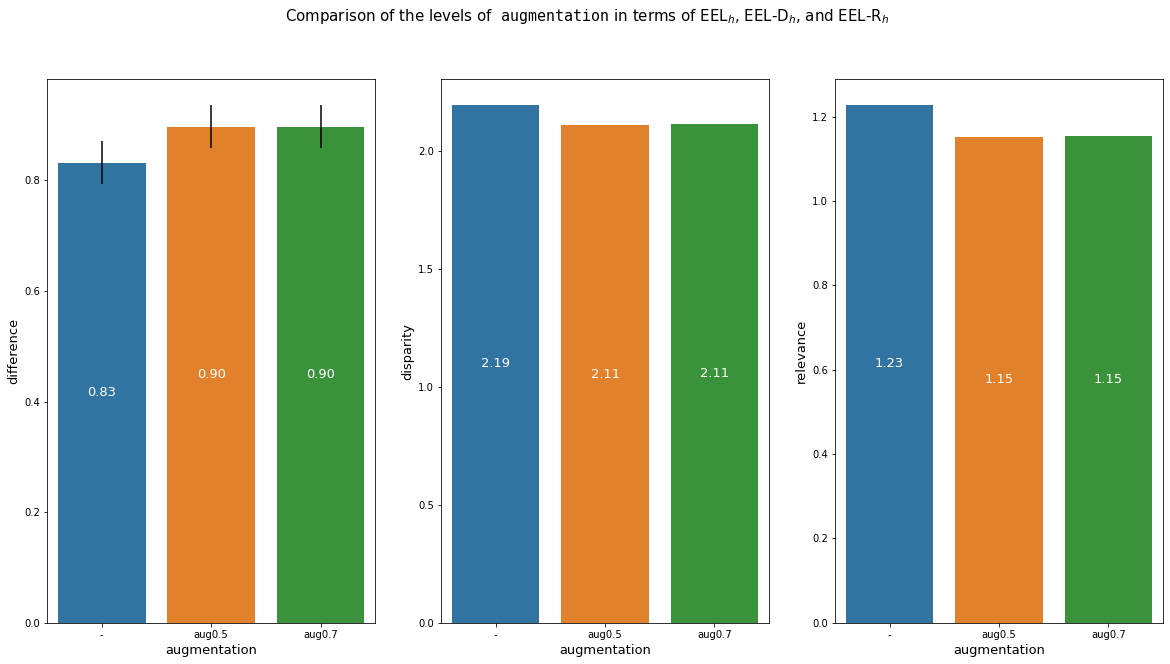

In [32]:
plt.rcParams["axes.labelsize"] = 13
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.sort_values(by='augmentation').groupby('augmentation')
means = groups['difference'].mean()
m2 = means['aug0.5']
n2 = len(groups.get_group('aug0.5'))
m3 = means['aug0.7']
n3 = len(groups.get_group('aug0.7'))
m1 = means['-']
n1 = len(groups.get_group('-'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

_ = fig.suptitle(r'Comparison of the levels of  $\mathtt{augmentation}$ in terms of EEL$_{h}$, EEL-D$_{h}$, and EEL-R$_{h}$', fontsize = 15)

_ = sns.barplot(x='augmentation', y='difference',ci=None, yerr=[c1,c2,c3], data=lambdata.sort_values(by='augmentation'),ax=axs[0])
_ = sns.barplot(x='augmentation', y='disparity', ci=None, data=lambdata.sort_values(by='augmentation'), ax=axs[1])
_ = sns.barplot(x='augmentation', y='relevance', ci=None, data=lambdata.sort_values(by='augmentation'), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)

_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)

_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)





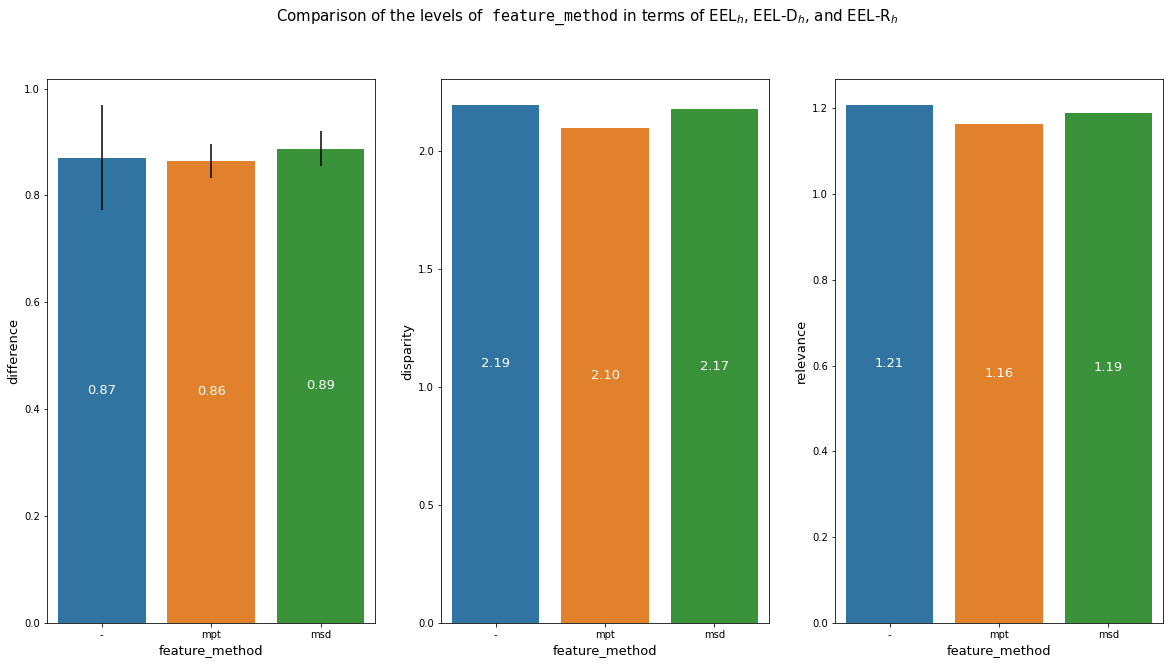

In [33]:
plt.rcParams["axes.labelsize"] = 13
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.sort_values(by='feature_method').groupby('feature_method')
means = groups['difference'].mean()
m2 = means['mpt']
n2 = len(groups.get_group('mpt'))
m3 = means['msd']
n3 = len(groups.get_group('msd'))
m1 = means['-']
n1 = len(groups.get_group('-'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

_ = fig.suptitle(r'Comparison of the levels of  $\mathtt{feature\_method}$ in terms of EEL$_{h}$, EEL-D$_{h}$, and EEL-R$_{h}$', fontsize = 15)

_ = sns.barplot(x='feature_method', y='difference',ci=None, yerr=[c1,c2,c3], data=lambdata.sort_values(by='feature_method'),ax=axs[0])
_ = sns.barplot(x='feature_method', y='disparity', ci=None, data=lambdata.sort_values(by='feature_method'), ax=axs[1])
_ = sns.barplot(x='feature_method', y='relevance', ci=None, data=lambdata.sort_values(by='feature_method'), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)

_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)

_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)





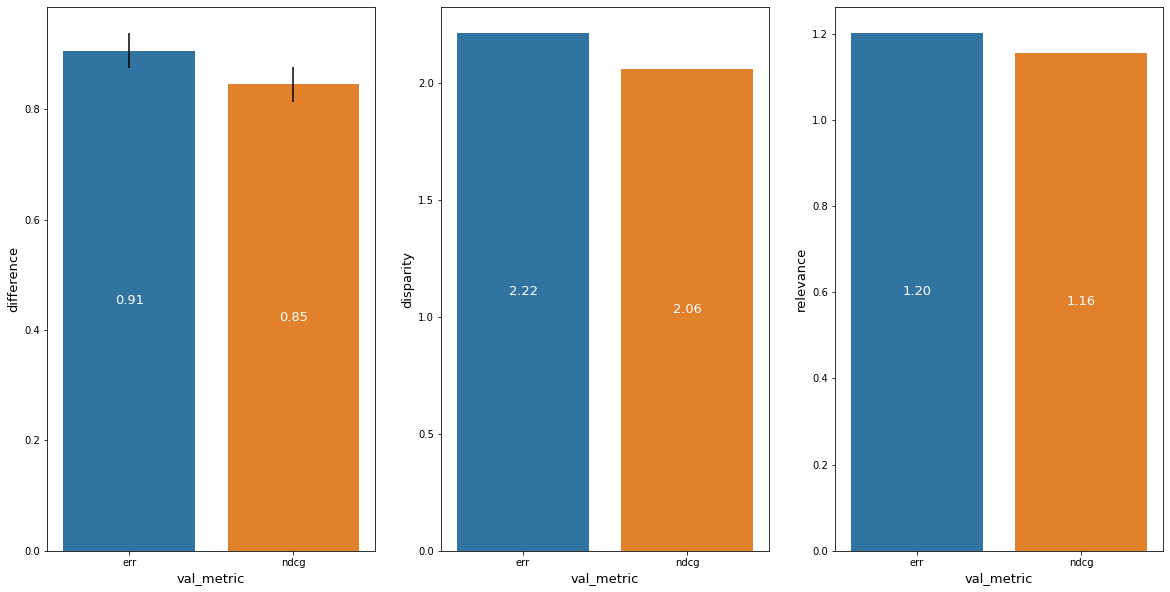

In [34]:
plt.rcParams["axes.labelsize"] = 13

ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('val_metric')
means = groups['difference'].mean()
m1 = means['err']
n1 = len(groups.get_group('err'))
m2 = means['ndcg']
n2 = len(groups.get_group('ndcg'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of $\mathtt{val\_metric}$ in terms of EEL$_{h}$, EEL-D$_{h}$, and EEL-R$_{h}$', fontsize = 15)

sns.barplot(x='val_metric', y='difference',ci=None, yerr=[c1,c2], data=lambdata,ax=axs[0])
sns.barplot(x='val_metric', y='disparity', ci=None, data=lambdata, ax=axs[1])
sns.barplot(x='val_metric', y='relevance', ci=None, data=lambdata, ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



### ANOVA of all main factors vs EEL_ind

We only have one replication per cell so we can't look at interactions.

In [35]:
def full_eval_run(ivs, dv, data):
    ivs_for_formula = [f'C({iv})' for iv in ivs]
    formula = f"{dv} ~ {' + '.join(ivs_for_formula)}"
    lm = ols(formula, data).fit()
    anova = anova_lm(lm)
    print(anova)
    

In [36]:
with pd.option_context('precision', 5, 'display.float_format', lambda x: '%.5f' % x):
    formula = "difference_ind ~ C(augmentation) + C(feature_method) + C(val_metric) + C(qid)"
    lm = ols(formula, lambdata).fit()
    lm.summary()
    print(anova_lm(lm))

                          df    sum_sq  mean_sq        F  PR(>F)
C(augmentation)      2.00000   1.78448  0.89224  6.67398 0.00129
C(feature_method)    2.00000   2.60883  1.30442  9.75710 0.00006
C(val_metric)        1.00000   4.21711  4.21711 31.54414 0.00000
C(qid)              19.00000 172.06359  9.05598 67.73913 0.00000
Residual          2255.00000 301.46878  0.13369      NaN     NaN


#### ANOVA effect sizes

In [37]:
print_omegasq('augmentation',lambdata)
print_omegasq('val_metric',lambdata)
print_omegasq('feature_method',lambdata)
print_omegasq('qid',lambdata)

482.0091020912236
306.328104293435
augmentation
omega-squared	omega-squared partial
0.00315			0.00495

482.0091020912236
308.8944235585387
val_metric
omega-squared	omega-squared partial
0.00847			0.01322

482.0091020912236
307.1524637185162
feature_method
omega-squared	omega-squared partial
0.00486			0.00762

482.0091020912236
474.3345101821618
qid
omega-squared	omega-squared partial
0.3517			0.35739



#### Tukey HSD

In [38]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference_ind'], groups=lambdata['augmentation'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     - aug0.5   0.0165 0.7424 -0.0387 0.0718  False
     - aug0.7   0.0659 0.0145  0.0106 0.1211   True
aug0.5 aug0.7   0.0493 0.0913 -0.0059 0.1046  False
---------------------------------------------------


In [39]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference_ind'], groups=lambdata['feature_method'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     -    mpt  -0.1371 0.0055 -0.2406 -0.0335   True
     -    msd  -0.0914 0.0962  -0.195  0.0121  False
   mpt    msd   0.0456 0.0545 -0.0007   0.092  False
----------------------------------------------------


In [40]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference_ind'], groups=lambdata['val_metric'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   err   ndcg   -0.086 0.001 -0.1236 -0.0484   True
---------------------------------------------------


In [41]:
lambdata.groupby('val_metric')['difference_ind'].mean()

val_metric
err    1.48953
ndcg   1.40351
Name: difference_ind, dtype: float64

#### cohen's d

In [42]:
means = lambdata.groupby('augmentation')['difference_ind'].mean()
means

augmentation
-        1.41906
aug0.5   1.43558
aug0.7   1.48492
Name: difference_ind, dtype: float64

In [43]:
# augmentation
means = lambdata.groupby('augmentation')['difference_ind'].mean()
m1 = means['-']
m2 = means['aug0.7']
m3 = means['aug0.5']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))


0.18011704973651507
0.045191688889215174
0.1349253608472999


In [44]:
# feature_method
means = lambdata.groupby('feature_method')['difference_ind'].mean()
m1 = means['-']
m2 = means['mpt']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.37489206987875034


In [45]:
# val_metric
means = lambdata.groupby('val_metric')['difference_ind'].mean()
m1 = means['ndcg']
m2 = means['err']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.23524581201082512


ALL the effects are small!

#### Visualize performance in term of difference, disparity, relevance + bar charts

In [46]:
lambdata.sort_values(by='augmentation').groupby('augmentation')['difference_ind'].mean()

augmentation
-        1.41906
aug0.5   1.43558
aug0.7   1.48492
Name: difference_ind, dtype: float64

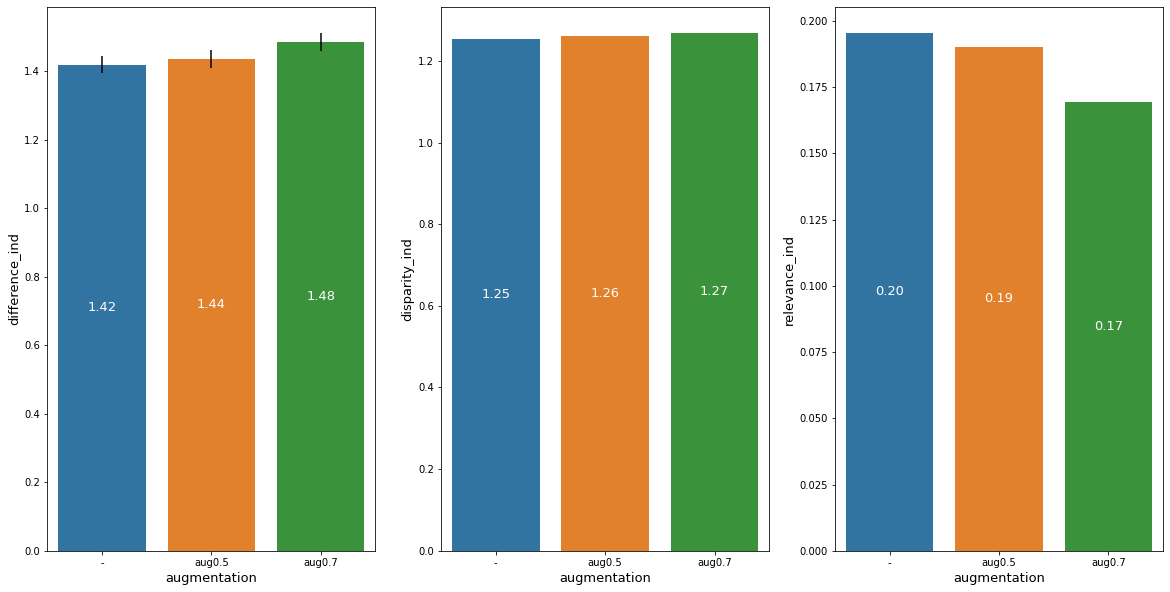

In [47]:
plt.rcParams["axes.labelsize"] = 13
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.sort_values(by='augmentation').groupby('augmentation')
means = groups['difference_ind'].mean()
m2 = means['aug0.5']
n2 = len(groups.get_group('aug0.5'))
m3 = means['aug0.7']
n3 = len(groups.get_group('aug0.7'))
m1 = means['-']
n1 = len(groups.get_group('-'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of  $\mathtt{augmentation}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='augmentation', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=lambdata.sort_values(by='augmentation'),ax=axs[0])
sns.barplot(x='augmentation', y='disparity_ind', ci=None, data=lambdata.sort_values(by='augmentation').sort_values(by='augmentation'), ax=axs[1])
sns.barplot(x='augmentation', y='relevance_ind', ci=None, data=lambdata.sort_values(by='augmentation'), ax=axs[2])


_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)


In [48]:
lambdata.groupby('feature_method').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
feature_method,,,,,,,
-,0.87068,2.19271,1.20761,1.55476,1.27531,0.13795,39200.95000
mpt,0.86427,2.09751,1.16322,1.41769,1.25703,0.19734,39200.95000
msd,0.88775,2.17402,1.18974,1.46333,1.26342,0.17772,39200.95000


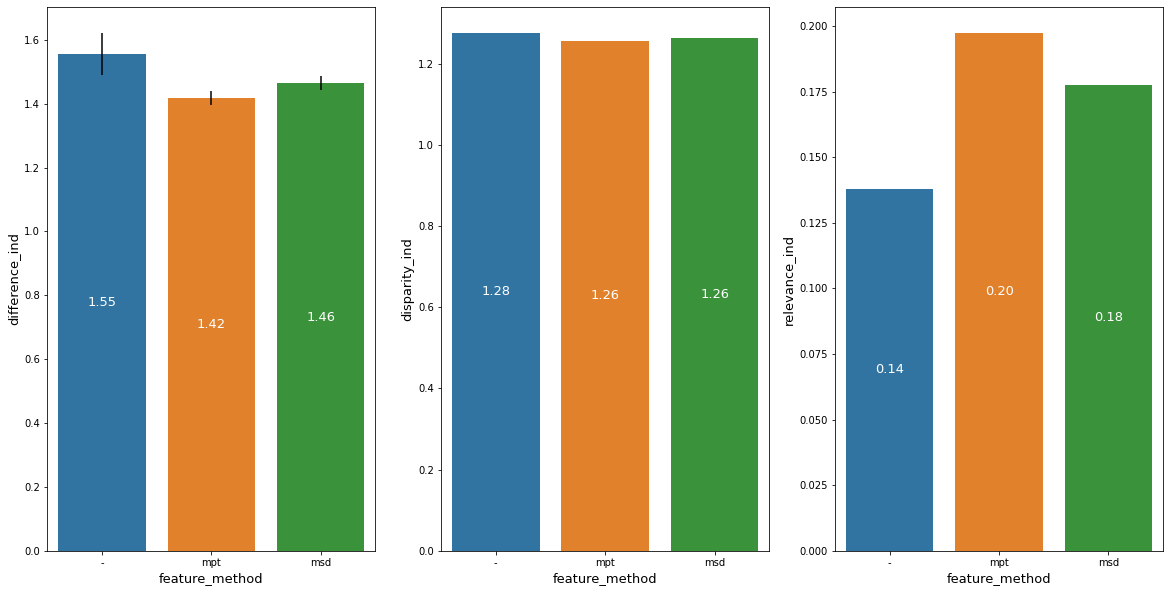

In [49]:
plt.rcParams["axes.labelsize"] = 13
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.sort_values(by='feature_method').groupby('feature_method')
means = groups['difference_ind'].mean()
m2 = means['mpt']
n2 = len(groups.get_group('mpt'))
m3 = means['msd']
n3 = len(groups.get_group('msd'))
m1 = means['-']
n1 = len(groups.get_group('-'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of  $\mathtt{feature\_method}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='feature_method', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=lambdata.sort_values(by='feature_method'),ax=axs[0])
sns.barplot(x='feature_method', y='disparity_ind', ci=None, data=lambdata.sort_values(by='feature_method'), ax=axs[1])
sns.barplot(x='feature_method', y='relevance_ind', ci=None, data=lambdata.sort_values(by='feature_method'), ax=axs[2])


_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)


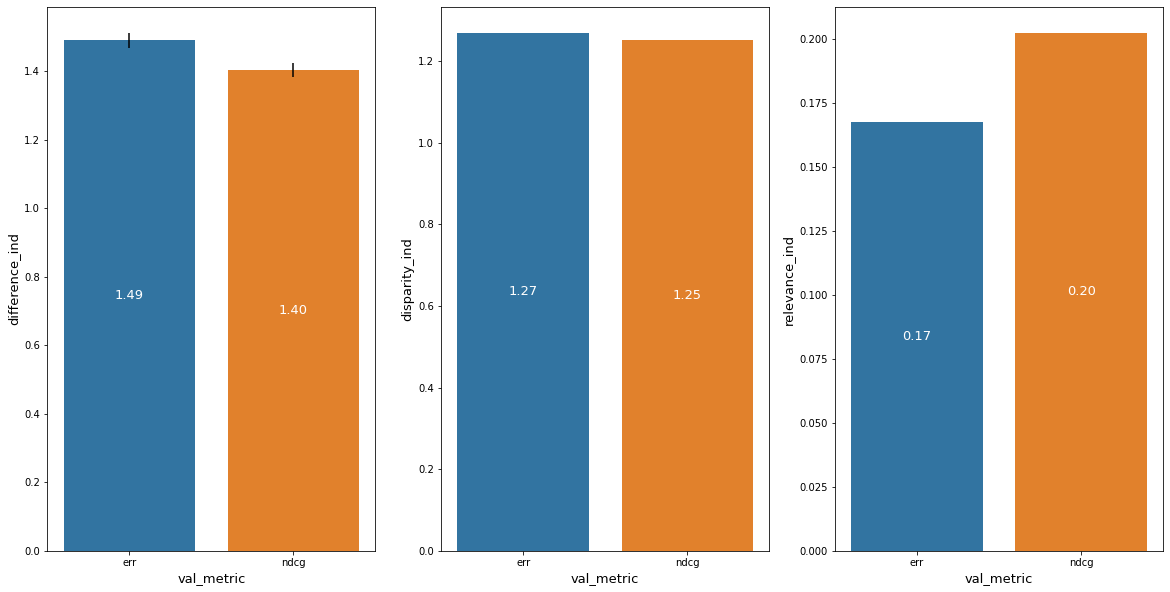

In [50]:
plt.rcParams["axes.labelsize"] = 13
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('val_metric')
means = groups['difference_ind'].mean()
m1 = means['err']
n1 = len(groups.get_group('err'))
m2 = means['ndcg']
n2 = len(groups.get_group('ndcg'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# _ = fig.suptitle(r'Comparison of the levels of  $\mathtt{val\_metric}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='val_metric', y='difference_ind',ci=None, yerr=[c1,c2], data=lambdata,ax=axs[0])
sns.barplot(x='val_metric', y='disparity_ind', ci=None, data=lambdata, ax=axs[1])
sns.barplot(x='val_metric', y='relevance_ind', ci=None, data=lambdata, ax=axs[2])


_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)

In [51]:
lambdata.sort_values(by='feature_method').groupby('feature_method')['difference_ind'].mean()

feature_method
-     1.55476
mpt   1.41769
msd   1.46333
Name: difference_ind, dtype: float64

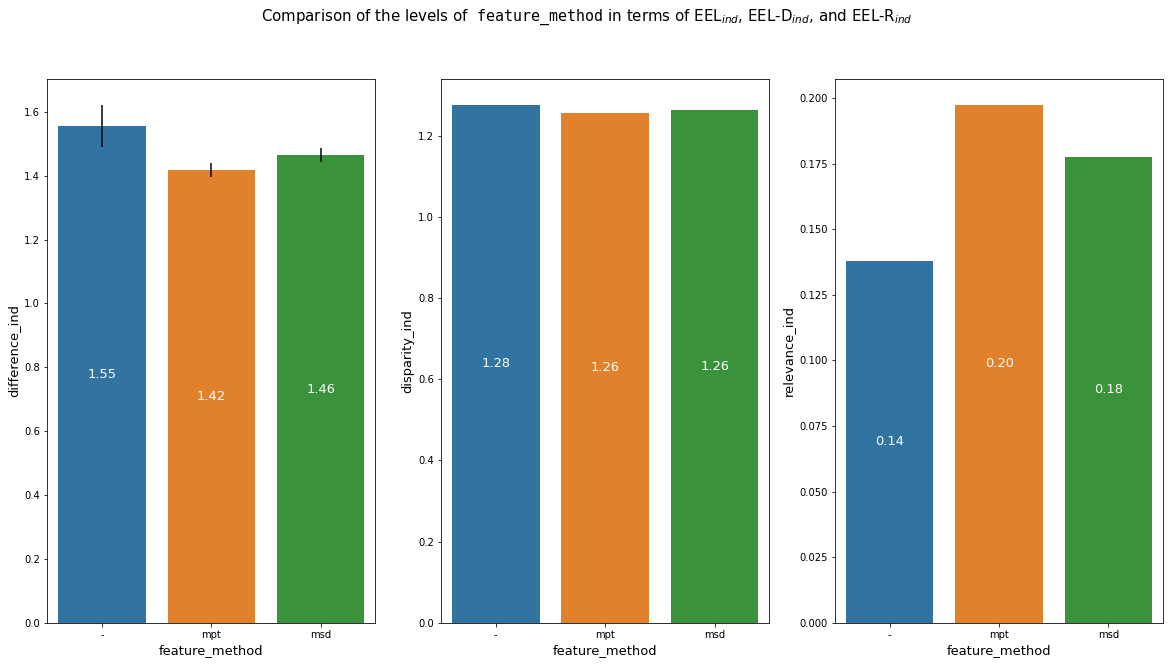

In [52]:
plt.rcParams["axes.labelsize"] = 13
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.sort_values(by='feature_method').groupby('feature_method')
means = groups['difference_ind'].mean()
m1 = means['-']
n1 = len(groups.get_group('-'))
m2 = means['mpt']
n2 = len(groups.get_group('mpt'))
m3 = means['msd']
n3 = len(groups.get_group('msd'))


c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

_ = fig.suptitle(r'Comparison of the levels of  $\mathtt{feature\_method}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='feature_method', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=lambdata.sort_values(by='feature_method'),ax=axs[0])
sns.barplot(x='feature_method', y='disparity_ind',ci=None, data=lambdata.sort_values(by='feature_method'),ax=axs[1])
sns.barplot(x='feature_method', y='relevance_ind',ci=None, data=lambdata.sort_values(by='feature_method'),ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)

### ANOVA feature_method vs EEL_ind
Do it only on the data that has good values for the other factors?

In [53]:
formula = "difference_ind ~ C(augmentation) + C(val_metric) + C(num_features) + C(balancing_factor) + C(qid)"
lm = ols(formula, lambdata[lambdata.feature_method == 'mpt']).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.00000,1.20227,0.60114,4.43508,0.01208
C(val_metric),1.00000,3.08481,3.08481,22.75914,0.00000
C(num_features),2.00000,0.06930,0.03465,0.25564,0.77447
C(balancing_factor),2.00000,1.22172,0.61086,4.50683,0.01125
C(qid),19.00000,82.47734,4.34091,32.02647,0.00000
Residual,1053.00000,142.72511,0.13554,NaN,NaN


#### Effect size

In [54]:
print_omegasq('augmentation',lambdata[lambdata.feature_method == 'mpt'])
print_omegasq('val_metric',lambdata[lambdata.feature_method == 'mpt'])
print_omegasq('num_features',lambdata[lambdata.feature_method == 'mpt'])
print_omegasq('balancing_factor',lambdata[lambdata.feature_method == 'mpt'])
print_omegasq('qid',lambdata[lambdata.feature_method == 'mpt'])

230.64501455947934
147.31592322607554
augmentation
omega-squared	omega-squared partial
0.00404			0.00632

230.64501455947934
149.33399687363308
val_metric
omega-squared	omega-squared partial
0.01279			0.01975

230.64501455947934
146.18294772047815
num_features
omega-squared	omega-squared partial
-0.00087			-0.00138

230.64501455947934
147.33537382578848
balancing_factor
omega-squared	omega-squared partial
0.00412			0.00645

230.64501455947934
226.2867825200916
qid
omega-squared	omega-squared partial
0.34643			0.3531



#### Tukey

In [55]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata[lambdata.feature_method == 'mpt']['difference_ind'], groups=lambdata[lambdata.feature_method == 'mpt']['augmentation'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     - aug0.5  -0.0196 0.8172 -0.1004 0.0611  False
     - aug0.7   0.0589 0.2017 -0.0219 0.1396  False
aug0.5 aug0.7   0.0785 0.0588 -0.0022 0.1593  False
---------------------------------------------------


In [56]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata[lambdata.feature_method == 'mpt']['difference_ind'], groups=lambdata[lambdata.feature_method == 'mpt']['val_metric'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   err   ndcg  -0.1069 0.001 -0.1618 -0.052   True
--------------------------------------------------


In [57]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata[lambdata.feature_method == 'mpt']['difference_ind'], groups=lambdata[lambdata.feature_method == 'mpt']['balancing_factor'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.1    0.5  -0.0665 0.1302 -0.1472 0.0143  False
   0.1    0.9  -0.0754 0.0733 -0.1561 0.0054  False
   0.5    0.9  -0.0089    0.9 -0.0897 0.0719  False
---------------------------------------------------


#### Tukey effect

#### Visualize performance in term of difference, disparity, relevance + bar charts

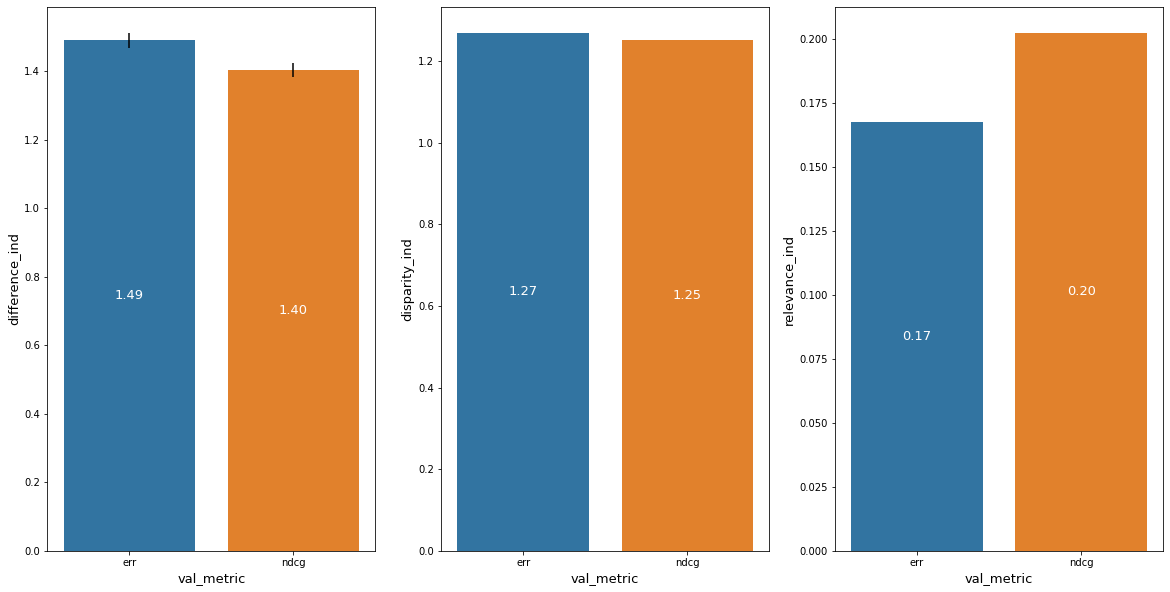

In [58]:
plt.rcParams["axes.labelsize"] = 13

ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('val_metric')
means = groups['difference_ind'].mean()
m1 = means['err']
n1 = len(groups.get_group('err'))
m2 = means['ndcg']
n2 = len(groups.get_group('ndcg'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of $\mathtt{val\_metric}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='val_metric', y='difference_ind',ci=None, yerr=[c1,c2], data=lambdata,ax=axs[0])
sns.barplot(x='val_metric', y='disparity_ind', ci=None, data=lambdata, ax=axs[1])
sns.barplot(x='val_metric', y='relevance_ind', ci=None, data=lambdata, ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



## Are the values of the base versions of LM improved by post processing with RFR?

### Select data

In [59]:
lmrfr_base = experiments.query('(ranker == "lambdamart" or ranker == "rfr") and ((augmentation == "noaug" or augmentation == "-") and feature_method == "-" and val_metric == "ndcg")')
lmrfr_base.augmentation = lmrfr_base.augmentation.replace('noaug','-')
lmrfr_base = lmrfr_base.reset_index(drop=True)
lmrfr_base

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.57712,2.79229,1.66427,1.68622,1.32940,0.04208,3462,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
1,1.21999,2.38827,1.02972,1.98201,1.33236,0.06666,8940,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
2,0.46480,2.26661,1.50561,1.61721,1.32943,0.03354,10795,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
3,0.38409,1.38503,0.83105,0.96625,1.07941,0.13739,12073,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
4,0.17772,2.82322,2.18903,2.05038,1.33309,0.03239,12096,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.38618,2.47630,1.60279,0.37829,0.20984,0.13627,64062,rfr,lambdamart_noaug_ndcg_nofeat,doc,-,-,-,-,ndcg,-,-,-,doc_-
96,0.07816,2.55821,2.16614,0.55271,0.39464,0.31245,66637,rfr,lambdamart_noaug_ndcg_nofeat,doc,-,-,-,-,ndcg,-,-,-,doc_-
97,0.20991,1.50974,1.50326,0.55891,0.39690,0.31049,67404,rfr,lambdamart_noaug_ndcg_nofeat,doc,-,-,-,-,ndcg,-,-,-,doc_-
98,0.25001,1.36099,1.01830,0.54435,0.33733,0.28764,70673,rfr,lambdamart_noaug_ndcg_nofeat,doc,-,-,-,-,ndcg,-,-,-,doc_-


In [60]:
lmrfr_base.ranker.value_counts()

rfr           80
lambdamart    20
Name: ranker, dtype: int64

In [61]:
lmrfr_base.augmentation.value_counts()

-    100
Name: augmentation, dtype: int64

In [62]:
lmrfr_base.val_metric.value_counts()

ndcg    100
Name: val_metric, dtype: int64

In [63]:
lmrfr_base.feature_method.value_counts()

-    100
Name: feature_method, dtype: int64

In [64]:
lmrfr_base.groupby('ranker').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
ranker,,,,,,,
lambdamart,0.76191,2.15418,1.24273,1.37777,1.23914,0.20836,39200.95000
rfr,0.48253,1.66110,1.13588,0.53618,0.28888,0.15402,39200.95000


In [65]:
lmrfr_base.groupby('augmentation').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
augmentation,,,,,,,
-,0.53841,1.75972,1.15725,0.70450,0.47893,0.16489,39200.95000


In [66]:
lmrfr_base.groupby('val_metric').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
val_metric,,,,,,,
ndcg,0.53841,1.75972,1.15725,0.70450,0.47893,0.16489,39200.95000


In [67]:
lmrfr_base.groupby('feature_method').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
feature_method,,,,,,,
-,0.53841,1.75972,1.15725,0.70450,0.47893,0.16489,39200.95000


#### EEL

In [68]:
formula = "difference ~ C(ranker) + C(qid)"
lm = ols(formula, lmrfr_base).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(ranker),1.00000,1.24887,1.24887,27.19939,0.00000
C(qid),19.00000,36.38602,1.91505,41.70828,0.00000
Residual,79.00000,3.62732,0.04592,NaN,NaN


#### ANOVA effect size

In [69]:
print_omegasq('ranker',lmrfr_base)
print_omegasq('qid',lmrfr_base)

41.2162940572384
5.794498845567203
ranker
omega-squared	omega-squared partial
0.02919			0.2076

41.2162940572384
40.10516871205592
qid
omega-squared	omega-squared partial
0.86164			0.88551



#### Tukey

In [70]:
lmrfr_base.groupby('ranker').count()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
ranker,,,,,,,,,,,,,,,,,,
lambdamart,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
rfr,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80


In [71]:
lmrfr_base.groupby('ranker').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
ranker,,,,,,,
lambdamart,0.76191,2.15418,1.24273,1.37777,1.23914,0.20836,39200.95000
rfr,0.48253,1.66110,1.13588,0.53618,0.28888,0.15402,39200.95000


In [72]:
17.97 *  math.sqrt((0.04592 / 2) * (1/20 + 1/80))

0.6807286474800366

In [73]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr_base['difference'], groups=lmrfr_base['ranker'], alpha=0.05)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1   group2 meandiff p-adj   lower  upper  reject
-------------------------------------------------------
lambdamart    rfr  -0.2794 0.0834 -0.5964 0.0376  False
-------------------------------------------------------


#### Tukey effect size

In [74]:
means = lmrfr_base.groupby('ranker')['difference'].mean()
m1 = means['lambdamart']
m2 = means['rfr']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


1.3038258778691592


#### Visualize performance in terms of difference, disparity, relevance + error bars


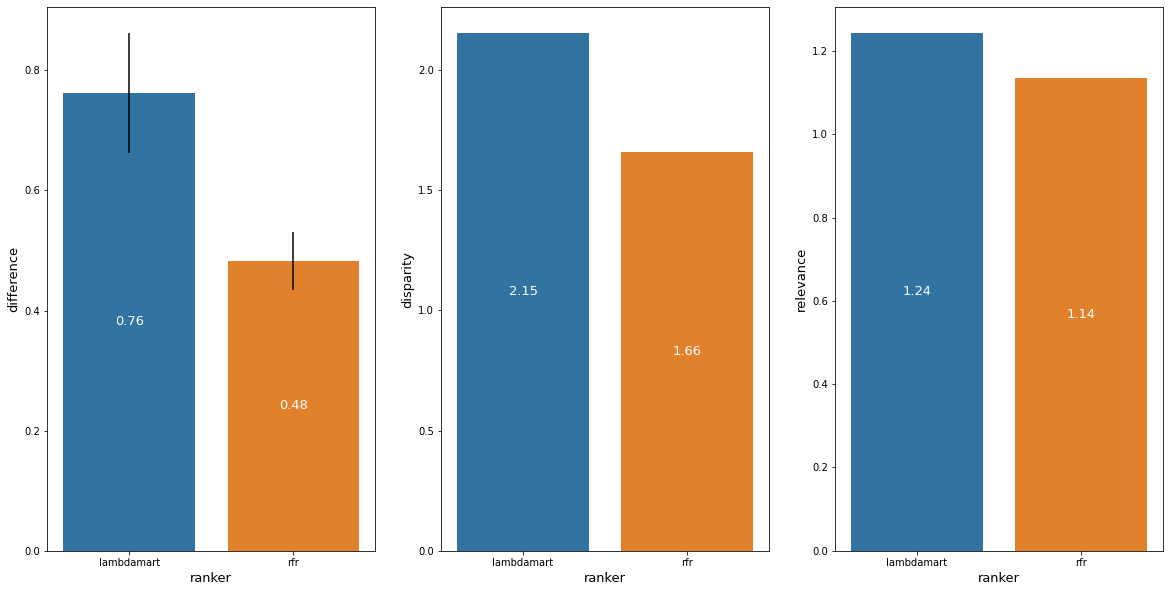

In [75]:
plt.rcParams["axes.labelsize"] = 13

ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr_base.groupby('ranker')
means = groups['difference'].mean()
m1 = means['lambdamart']
n1 = len(groups.get_group('lambdamart'))
m2 = means['rfr']
n2 = len(groups.get_group('rfr'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of $\mathtt{ranker}$ in terms of EEL$_h$, EEL-D$_{h}$, and EEL-R$_{h}$', fontsize = 15)

sns.barplot(x='ranker', y='difference',ci=None, yerr=[c1,c2], data=lmrfr_base,ax=axs[0])
sns.barplot(x='ranker', y='disparity', ci=None, data=lmrfr_base, ax=axs[1])
sns.barplot(x='ranker', y='relevance', ci=None, data=lmrfr_base, ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



#### Grouping factor for RFR

In [76]:
lmrfr_base[lmrfr_base.ranker == 'rfr'][['gr','difference','disparity','relevance','difference_ind','disparity_ind','relevance_ind']].groupby('gr').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind
gr,,,,,,
author_ind,0.49482,1.65549,1.12694,0.55410,0.30060,0.15092
author_none,0.49510,1.65646,1.12728,0.55427,0.30096,0.15102
author_one,0.49716,1.66341,1.12972,0.55714,0.29938,0.14880
doc_-,0.44306,1.66905,1.15959,0.47920,0.25456,0.16535


In [77]:
formula = "difference ~ C(gr) + C(qid)"
lm = ols(formula, lmrfr_base[lmrfr_base.ranker == 'rfr']).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.04162,0.01387,0.54987,0.65028
C(qid),19.00000,30.15118,1.58690,62.90267,0.00000
Residual,57.00000,1.43799,0.02523,NaN,NaN


##### Effect sizes

In [78]:
print_omegasq('qid',lmrfr_base[lmrfr_base.ranker == 'rfr'])

31.60556312265821
31.690086637239013
qid
omega-squared	omega-squared partial
0.93882			0.93631



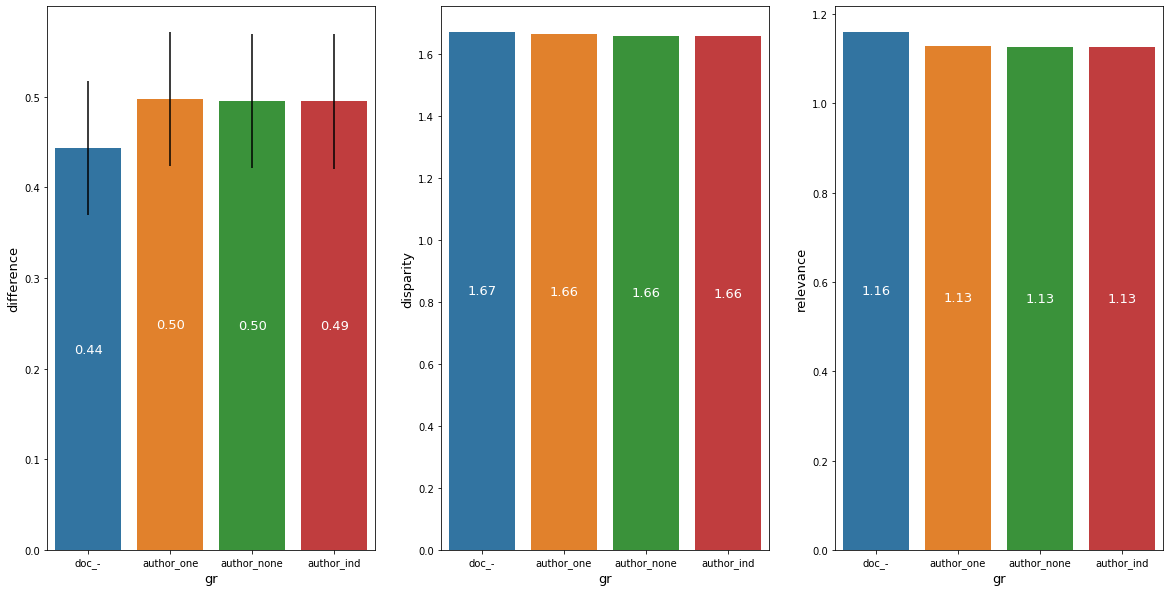

In [79]:
plt.rcParams["axes.labelsize"] = 13


ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr_base[lmrfr_base.ranker == 'rfr'].sort_values(by='gr',ascending=False).groupby('gr')
means = groups['difference'].mean()
m1 = means['doc_-']
n1 = len(groups.get_group('doc_-'))
m2 = means['author_one']
n2 = len(groups.get_group('author_one'))

m3 = means['author_none']
n3 = len(groups.get_group('author_none'))
m4 = means['author_ind']
n4 = len(groups.get_group('author_ind'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of $\mathtt{gr}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='gr', y='difference',ci=None, yerr=[c1,c2,c3,c4], data=lmrfr_base[lmrfr_base.ranker == 'rfr'].sort_values(by='gr',ascending=False),ax=axs[0])
sns.barplot(x='gr', y='disparity', ci=None, data=lmrfr_base[lmrfr_base.ranker == 'rfr'].sort_values(by='gr',ascending=False), ax=axs[1])
sns.barplot(x='gr', y='relevance', ci=None, data=lmrfr_base[lmrfr_base.ranker == 'rfr'].sort_values(by='gr',ascending=False), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



#### EEL ind

In [80]:
formula = "difference_ind ~ C(ranker) + C(qid)"
lm = ols(formula, lmrfr_base).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(ranker),1.00000,11.33260,11.33260,190.69293,0.00000
C(qid),19.00000,7.84813,0.41306,6.95052,0.00000
Residual,79.00000,4.69485,0.05943,NaN,NaN


#### ANOVA effect size

In [81]:
print_omegasq('ranker',lmrfr_base)
print_omegasq('qid',lmrfr_base)

23.816155088412387
17.216028489176555
ranker
omega-squared	omega-squared partial
0.47334			0.65481

23.816155088412387
12.661837873766972
qid
omega-squared	omega-squared partial
0.28212			0.53065



#### Tukey

In [82]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr_base['difference_ind'], groups=lmrfr_base['ranker'], alpha=0.05)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1   group2 meandiff p-adj  lower   upper  reject
-------------------------------------------------------
lambdamart    rfr  -0.8416 0.001 -1.0191 -0.6641   True
-------------------------------------------------------


#### Tukey effect size

In [83]:
means = lmrfr_base.groupby('ranker')['difference_ind'].mean()
m1 = means['lambdamart']
m2 = means['rfr']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


3.4522902813180014


#### Visualize performance in terms of difference, disparity, relevance + error bars


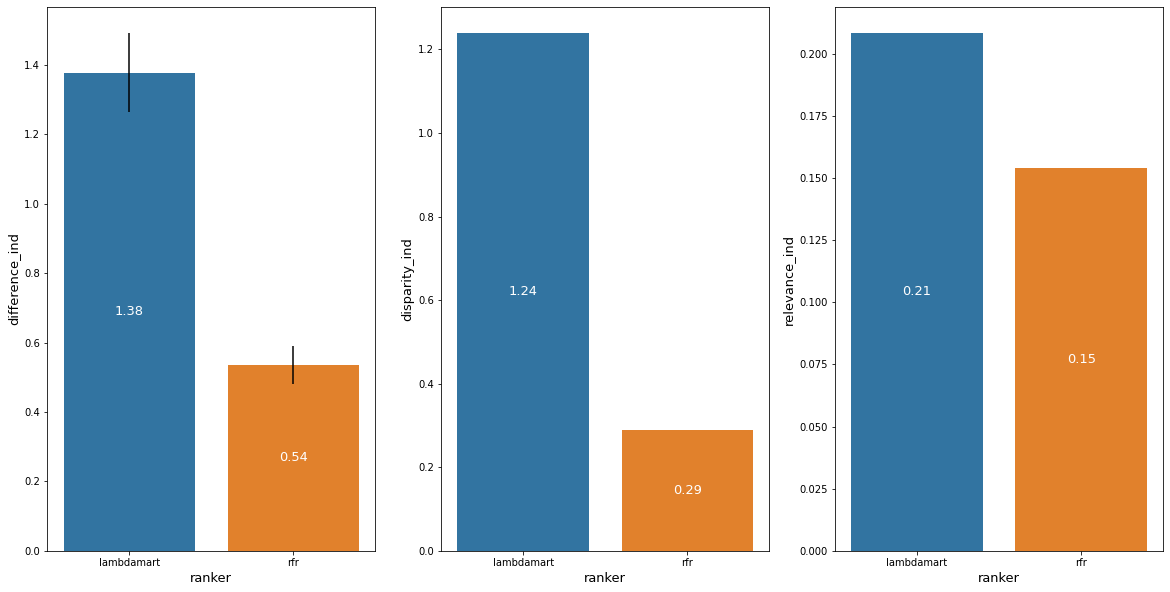

In [84]:
plt.rcParams["axes.labelsize"] = 13

ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr_base.groupby('ranker')
means = groups['difference_ind'].mean()
m1 = means['lambdamart']
n1 = len(groups.get_group('lambdamart'))
m2 = means['rfr']
n2 = len(groups.get_group('rfr'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of $\mathtt{ranker}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='ranker', y='difference_ind',ci=None, yerr=[c1,c2], data=lmrfr_base,ax=axs[0])
sns.barplot(x='ranker', y='disparity_ind', ci=None, data=lmrfr_base, ax=axs[1])
sns.barplot(x='ranker', y='relevance_ind', ci=None, data=lmrfr_base, ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



#### Grouping factor for RFR

In [85]:
formula = "difference_ind ~ C(gr) + C(qid)"
lm = ols(formula, lmrfr_base[lmrfr_base.ranker == 'rfr']).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.08669,0.02890,3.12262,0.03284
C(qid),19.00000,6.41730,0.33775,36.49645,0.00000
Residual,57.00000,0.52750,0.00925,NaN,NaN


##### Effect sizes

In [86]:
print_omegasq('gr', lmrfr_base[lmrfr_base.ranker == 'rfr'])
print_omegasq('qid', lmrfr_base[lmrfr_base.ranker == 'rfr'])

7.022235534719808
0.7992818418802983
gr
omega-squared	omega-squared partial
0.00839			0.07373

7.022235534719808
6.9818136604638585
qid
omega-squared	omega-squared partial
0.88881			0.89396



##### Tukey

In [87]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr_base[lmrfr_base.ranker == 'rfr']['difference_ind'], groups=lmrfr_base[lmrfr_base.ranker == 'rfr']['gr'], alpha=0.05)
print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
 author_ind author_none   0.0002    0.9 -0.2509 0.2513  False
 author_ind  author_one    0.003    0.9 -0.2481 0.2541  False
 author_ind       doc_-  -0.0749 0.8454  -0.326 0.1762  False
author_none  author_one   0.0029    0.9 -0.2482  0.254  False
author_none       doc_-  -0.0751 0.8444 -0.3262  0.176  False
 author_one       doc_-  -0.0779 0.8277  -0.329 0.1732  False
-------------------------------------------------------------


##### Tukey effect size

In [88]:
means = lmrfr_base[lmrfr_base.ranker == 'rfr'].groupby('gr')['difference_ind'].mean()
m1 = means['doc_-']
m2 = means['author_none']
m3 = means['author_ind']
m4 = means['author_one']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(round(cohens_d(m1, m2, ms_error),2))
print(round(cohens_d(m1, m3, ms_error),2))
print(round(cohens_d(m1, m4, ms_error),2))


0.78
0.78
0.81


##### Visualize performance in terms of difference, disparity, relevance + error bars


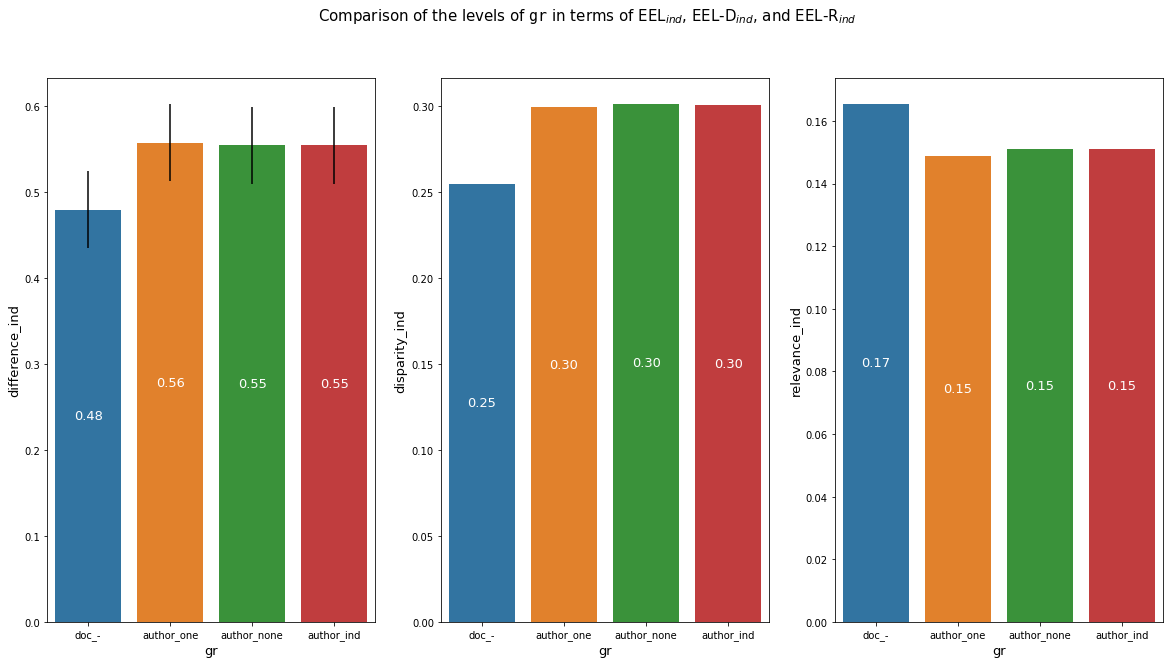

In [89]:
plt.rcParams["axes.labelsize"] = 13


ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr_base[lmrfr_base.ranker == 'rfr'].sort_values(by='gr',ascending=False).groupby('gr')
means = groups['difference_ind'].mean()
m1 = means['doc_-']
n1 = len(groups.get_group('doc_-'))
m2 = means['author_one']
n2 = len(groups.get_group('author_one'))

m3 = means['author_none']
n3 = len(groups.get_group('author_none'))
m4 = means['author_ind']
n4 = len(groups.get_group('author_ind'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of $\mathtt{gr}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='gr', y='difference_ind',ci=None, yerr=[c1,c2,c3,c4], data=lmrfr_base[lmrfr_base.ranker == 'rfr'].sort_values(by='gr',ascending=False),ax=axs[0])
sns.barplot(x='gr', y='disparity_ind', ci=None, data=lmrfr_base[lmrfr_base.ranker == 'rfr'].sort_values(by='gr',ascending=False), ax=axs[1])
sns.barplot(x='gr', y='relevance_ind', ci=None, data=lmrfr_base[lmrfr_base.ranker == 'rfr'].sort_values(by='gr',ascending=False), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



In [ ]:
plt.rcParams["axes.labelsize"] = 13


ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr[lmrfr.ranker == 'rfr'].sort_values('augmentation').groupby('augmentation')
means = groups['difference_ind'].mean()
m1 = means['-']
n1 = len(groups.get_group('-'))
m2 = means['aug0.5']
n2 = len(groups.get_group('aug0.5'))
m3 = means['aug0.7']
n3 = len(groups.get_group('aug0.7'))


c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

_ = fig.suptitle(r'Comparison of the levels of $\mathtt{augmentation}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='augmentation', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=lmrfr[lmrfr.ranker == 'rfr'].sort_values('augmentation'),ax=axs[0])
sns.barplot(x='augmentation', y='disparity_ind', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'].sort_values('augmentation'), ax=axs[1])
sns.barplot(x='augmentation', y='relevance_ind', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'].sort_values('augmentation'), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



#### How much overlap is there within rankings if we look at h-level grouping?
1. Load sample.
2. For each doc for each query annotate in which group they are.

In [ ]:
gt = pd.read_json('../pre_processing/resources/training/2020/TREC-Fair-Ranking-training-sample_-10.json',lines=True)
gt = gt.explode('documents')
gt['doc_id'] = gt.documents.apply(lambda row: row['doc_id'])
gt.head()

In [ ]:
grouping = pd.read_csv('../evaluation/resources/2020/groupings/full-annotations-DocHLevel-mixed_group.csv')
grouping.head()

In [ ]:
with pd.option_context('display.max_colwidth', 1000):
    print(pd.merge(gt[['qid','doc_id']],grouping,on='doc_id').groupby('qid').apply(lambda x: list(x.group)))

## Are the values of the base versions of LM improved by augmenting the data and post processing with RFR?

### Select data

In [ ]:
lmrfr = experiments.query('ranker == "lambdamart" or (ranker == "rfr" and source != "META_train" and source != "TEXT_train")')
lmrfr.augmentation = lmrfr.augmentation.replace('noaug','-')
lmrfr = lmrfr.reset_index(drop=True)
lmrfr

In [ ]:
lmrfr.groupby('ranker').mean()

In [ ]:
lmrfr.groupby('augmentation').mean()

In [ ]:
lmrfr.groupby('val_metric').mean()

In [ ]:
lmrfr.groupby('feature_method').mean()

#### EEL

In [ ]:
formula = "difference ~ C(ranker) + C(augmentation) + C(feature_method) + C(val_metric) + C(qid)"
lm = ols(formula, lmrfr).fit()
lm.summary()
anova_lm(lm)

#### ANOVA effect size

In [ ]:
print_omegasq('val_metric',lmrfr)
print_omegasq('ranker',lmrfr)
print_omegasq('qid',lmrfr)

#### Tukey

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr['difference'], groups=lmrfr['ranker'], alpha=0.05)
print(tukey)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr['difference'], groups=lmrfr['val_metric'], alpha=0.05)
print(tukey)

#### Tukey effect size

In [ ]:
means = lmrfr.groupby('ranker')['difference'].mean()
m1 = means['lambdamart']
m2 = means['rfr']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


In [ ]:
means = lmrfr.groupby('val_metric')['difference'].mean()
m1 = means['err']
m2 = means['ndcg']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


#### Visualize performance in terms of difference, disparity, relevance + error bars


In [ ]:
plt.rcParams["axes.labelsize"] = 13

ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr.groupby('ranker')
means = groups['difference'].mean()
m1 = means['lambdamart']
n1 = len(groups.get_group('lambdamart'))
m2 = means['rfr']
n2 = len(groups.get_group('rfr'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

_ = fig.suptitle(r'Comparison of the levels of $\mathtt{ranker}$ in terms of EEL$_h$, EEL-D$_{h}$, and EEL-R$_{h}$', fontsize = 15)

sns.barplot(x='ranker', y='difference',ci=None, yerr=[c1,c2], data=lmrfr,ax=axs[0])
sns.barplot(x='ranker', y='disparity', ci=None, data=lmrfr, ax=axs[1])
sns.barplot(x='ranker', y='relevance', ci=None, data=lmrfr, ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



#### Grouping factor for RFR

In [ ]:
lmrfr[lmrfr.ranker == 'rfr'][['augmentation','difference','disparity','relevance','difference_ind','disparity_ind','relevance_ind']].groupby('augmentation').mean()

In [ ]:
lmrfr[lmrfr.ranker == 'rfr'][['feature_method','difference','disparity','relevance','difference_ind','disparity_ind','relevance_ind']].groupby('feature_method').mean()

In [ ]:
lmrfr[lmrfr.ranker == 'rfr'][['val_metric','difference','disparity','relevance','difference_ind','disparity_ind','relevance_ind']].groupby('val_metric').mean()

In [ ]:
lmrfr[lmrfr.ranker == 'rfr'][['gr','difference','disparity','relevance','difference_ind','disparity_ind','relevance_ind']].groupby('gr').mean()

In [ ]:
formula = "difference ~ C(augmentation) + C(feature_method) + C(val_metric) + C(gr) + C(qid)"
lm = ols(formula, lmrfr[lmrfr.ranker == 'rfr']).fit()
lm.summary()
anova_lm(lm)

##### Effect sizes

In [ ]:
print_omegasq('val_metric',lmrfr[lmrfr.ranker == 'rfr'])
print_omegasq('gr',lmrfr[lmrfr.ranker == 'rfr'])
print_omegasq('qid',lmrfr[lmrfr.ranker == 'rfr'])

##### Tukey

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr[lmrfr.ranker == 'rfr']['difference'], groups=lmrfr[lmrfr.ranker == 'rfr']['val_metric'], alpha=0.05)
print(tukey)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr[lmrfr.ranker == 'rfr']['difference'], groups=lmrfr[lmrfr.ranker == 'rfr']['gr'], alpha=0.05)
print(tukey)

##### Tukey effect size

In [ ]:
means = lmrfr[lmrfr.ranker == 'rfr'].groupby('val_metric')['difference'].mean()
m1 = means['err']
m2 = means['ndcg']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


In [ ]:
means = lmrfr[lmrfr.ranker == 'rfr'].groupby('gr')['difference'].mean()
m1 = means['doc_-']
m2 = means['author_none']
m3 = means['author_ind']
m4 = means['author_one']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m1, m4, ms_error))


##### Visualize performance in terms of difference, disparity, relevance + error bars


In [ ]:
plt.rcParams["axes.labelsize"] = 13

ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr[lmrfr.ranker == 'rfr'].groupby('gr')
means = groups['difference'].mean()
m1 = means['doc_-']
n1 = len(groups.get_group('doc_-'))
m2 = means['author_ind']
n2 = len(groups.get_group('author_ind'))

m3 = means['author_none']
n3 = len(groups.get_group('author_none'))
m4 = means['author_one']
n4 = len(groups.get_group('author_one'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

_ = fig.suptitle(r'Comparison of the levels of $\mathtt{gr}$ in terms of EEL$_{h}$, EEL-D$_{h}$, and EEL-R$_{h}$', fontsize = 15)

sns.barplot(x='gr', y='difference',ci=None, yerr=[c1,c2,c3,c4], data=lmrfr[lmrfr.ranker == 'rfr'],ax=axs[0])
sns.barplot(x='gr', y='disparity', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'], ax=axs[1])
sns.barplot(x='gr', y='relevance', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'], ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



#### EEL ind

In [ ]:
formula = "difference_ind ~ C(ranker) + C(augmentation) + C(feature_method) + C(val_metric) + C(qid)"
lm = ols(formula, lmrfr).fit()
lm.summary()
anova_lm(lm)

#### ANOVA effect size

In [ ]:
print_omegasq('ranker',lmrfr)
print_omegasq('augmentation',lmrfr)
print_omegasq('feature_method',lmrfr)
print_omegasq('val_metric',lmrfr)
print_omegasq('qid',lmrfr)

#### Tukey

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr['difference_ind'], groups=lmrfr['ranker'], alpha=0.05)
print(tukey)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr['difference_ind'], groups=lmrfr['val_metric'], alpha=0.05)
print(tukey)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr['difference_ind'], groups=lmrfr['augmentation'], alpha=0.05)
print(tukey)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr['difference_ind'], groups=lmrfr['feature_method'], alpha=0.05)
print(tukey)

#### Tukey effect size

In [ ]:
means = lmrfr.groupby('ranker')['difference'].mean()
m1 = means['lambdamart']
m2 = means['rfr']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


In [ ]:
means = lmrfr.groupby('val_metric')['difference'].mean()
m1 = means['err']
m2 = means['ndcg']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


In [ ]:
means = lmrfr.groupby('augmentation')['difference'].mean()
m1 = means['aug0.5']
m2 = means['aug0.7']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


#### Visualize performance in terms of difference, disparity, relevance + error bars


In [ ]:
plt.rcParams["axes.labelsize"] = 13

ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr.groupby('ranker')
means = groups['difference_ind'].mean()
m1 = means['lambdamart']
n1 = len(groups.get_group('lambdamart'))
m2 = means['rfr']
n2 = len(groups.get_group('rfr'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

_ = fig.suptitle(r'Comparison of the levels of $\mathtt{ranker}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='ranker', y='difference_ind',ci=None, yerr=[c1,c2], data=lmrfr,ax=axs[0])
sns.barplot(x='ranker', y='disparity_ind', ci=None, data=lmrfr, ax=axs[1])
sns.barplot(x='ranker', y='relevance_ind', ci=None, data=lmrfr, ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



In [ ]:
plt.rcParams["axes.labelsize"] = 13

ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr.groupby('val_metric')
means = groups['difference_ind'].mean()
m1 = means['err']
n1 = len(groups.get_group('err'))
m2 = means['ndcg']
n2 = len(groups.get_group('ndcg'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

_ = fig.suptitle(r'Comparison of the levels of $\mathtt{val\_metric}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='val_metric', y='difference_ind',ci=None, yerr=[c1,c2], data=lmrfr,ax=axs[0])
sns.barplot(x='val_metric', y='disparity_ind', ci=None, data=lmrfr, ax=axs[1])
sns.barplot(x='val_metric', y='relevance_ind', ci=None, data=lmrfr, ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



In [ ]:
plt.rcParams["axes.labelsize"] = 13

ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr.sort_values(by='augmentation').groupby('augmentation')
means = groups['difference_ind'].mean()
m1 = means['-']
n1 = len(groups.get_group('-'))
m2 = means['aug0.5']
n2 = len(groups.get_group('aug0.5'))
m3 = means['aug0.7']
n3 = len(groups.get_group('aug0.7'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

_ = fig.suptitle(r'Comparison of the levels of $\mathtt{augmentation}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='augmentation', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=lmrfr.sort_values(by='augmentation'),ax=axs[0])
sns.barplot(x='augmentation', y='disparity_ind', ci=None, data=lmrfr.sort_values(by='augmentation'), ax=axs[1])
sns.barplot(x='augmentation', y='relevance_ind', ci=None, data=lmrfr.sort_values(by='augmentation'), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



#### Grouping factor for RFR

In [ ]:
formula = "difference_ind ~ C(augmentation) + C(feature_method) + C(val_metric) + C(gr) + C(qid)"
lm = ols(formula, lmrfr[lmrfr.ranker == 'rfr']).fit()
lm.summary()
anova_lm(lm)

##### Effect sizes

In [ ]:
print_omegasq('augmentation', lmrfr[lmrfr.ranker == 'rfr'])
print_omegasq('feature_method', lmrfr[lmrfr.ranker == 'rfr'])
print_omegasq('val_metric', lmrfr[lmrfr.ranker == 'rfr'])
print_omegasq('gr', lmrfr[lmrfr.ranker == 'rfr'])
print_omegasq('qid', lmrfr[lmrfr.ranker == 'rfr'])

##### Tukey

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr[lmrfr.ranker == 'rfr']['difference_ind'], groups=lmrfr[lmrfr.ranker == 'rfr']['augmentation'], alpha=0.05)
print(tukey)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr[lmrfr.ranker == 'rfr']['difference_ind'], groups=lmrfr[lmrfr.ranker == 'rfr']['feature_method'], alpha=0.05)
print(tukey)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr[lmrfr.ranker == 'rfr']['difference_ind'], groups=lmrfr[lmrfr.ranker == 'rfr']['val_metric'], alpha=0.05)
print(tukey)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr[lmrfr.ranker == 'rfr']['difference_ind'], groups=lmrfr[lmrfr.ranker == 'rfr']['gr'], alpha=0.05)
print(tukey)

##### Tukey effect size

In [ ]:
means = lmrfr[lmrfr.ranker == 'rfr'].groupby('gr')['difference_ind'].mean()
m1 = means['doc_-']
m2 = means['author_none']
m3 = means['author_ind']
m4 = means['author_one']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(round(cohens_d(m1, m2, ms_error),2))
print(round(cohens_d(m1, m3, ms_error),2))
print(round(cohens_d(m1, m4, ms_error),2))


In [ ]:
means = lmrfr[lmrfr.ranker == 'rfr'].groupby('val_metric')['difference_ind'].mean()
m1 = means['err']
m2 = means['ndcg']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(round(cohens_d(m1, m2, ms_error),2))


In [ ]:
means = lmrfr[lmrfr.ranker == 'rfr'].groupby('augmentation')['difference_ind'].mean()
m1 = means['aug0.5']
m2 = means['aug0.7']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(round(cohens_d(m1, m2, ms_error),2))


##### Visualize performance in terms of difference, disparity, relevance + error bars


In [ ]:
plt.rcParams["axes.labelsize"] = 13


ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr[lmrfr.ranker == 'rfr'].sort_values(by='gr',ascending=False).groupby('gr')
means = groups['difference_ind'].mean()
m1 = means['doc_-']
n1 = len(groups.get_group('doc_-'))
m2 = means['author_one']
n2 = len(groups.get_group('author_one'))

m3 = means['author_none']
n3 = len(groups.get_group('author_none'))
m4 = means['author_ind']
n4 = len(groups.get_group('author_ind'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

_ = fig.suptitle(r'Comparison of the levels of $\mathtt{gr}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='gr', y='difference_ind',ci=None, yerr=[c1,c2,c3,c4], data=lmrfr[lmrfr.ranker == 'rfr'].sort_values(by='gr',ascending=False),ax=axs[0])
sns.barplot(x='gr', y='disparity_ind', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'].sort_values(by='gr',ascending=False), ax=axs[1])
sns.barplot(x='gr', y='relevance_ind', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'].sort_values(by='gr',ascending=False), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



In [ ]:
plt.rcParams["axes.labelsize"] = 13


ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr[lmrfr.ranker == 'rfr'].groupby('val_metric')
means = groups['difference_ind'].mean()
m1 = means['err']
n1 = len(groups.get_group('err'))
m2 = means['ndcg']
n2 = len(groups.get_group('ndcg'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

_ = fig.suptitle(r'Comparison of the levels of $\mathtt{val\_metric}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='val_metric', y='difference_ind',ci=None, yerr=[c1,c2], data=lmrfr[lmrfr.ranker == 'rfr'],ax=axs[0])
sns.barplot(x='val_metric', y='disparity_ind', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'], ax=axs[1])
sns.barplot(x='val_metric', y='relevance_ind', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'], ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



In [ ]:
plt.rcParams["axes.labelsize"] = 13


ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr[lmrfr.ranker == 'rfr'].sort_values('augmentation').groupby('augmentation')
means = groups['difference_ind'].mean()
m1 = means['-']
n1 = len(groups.get_group('-'))
m2 = means['aug0.5']
n2 = len(groups.get_group('aug0.5'))
m3 = means['aug0.7']
n3 = len(groups.get_group('aug0.7'))


c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

_ = fig.suptitle(r'Comparison of the levels of $\mathtt{augmentation}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='augmentation', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=lmrfr[lmrfr.ranker == 'rfr'].sort_values('augmentation'),ax=axs[0])
sns.barplot(x='augmentation', y='disparity_ind', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'].sort_values('augmentation'), ax=axs[1])
sns.barplot(x='augmentation', y='relevance_ind', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'].sort_values('augmentation'), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



#### How much overlap is there within rankings if we look at h-level grouping?
1. Load sample.
2. For each doc for each query annotate in which group they are.

In [ ]:
gt = pd.read_json('../pre_processing/resources/training/2020/TREC-Fair-Ranking-training-sample_-10.json',lines=True)
gt = gt.explode('documents')
gt['doc_id'] = gt.documents.apply(lambda row: row['doc_id'])
gt.head()

In [ ]:
grouping = pd.read_csv('../evaluation/resources/2020/groupings/full-annotations-DocHLevel-mixed_group.csv')
grouping.head()

In [ ]:
with pd.option_context('display.max_colwidth', 1000):
    print(pd.merge(gt[['qid','doc_id']],grouping,on='doc_id').groupby('qid').apply(lambda x: list(x.group)))

## Are the values of the base versions of AC improved by our changes?

### Select data

In [128]:
ackrdata = experiments.query('ranker == "ac" and (source == "TEXT_train" or source == "META_train")')
ackrdata = ackrdata.reset_index(drop=True)

ackrdata

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.09151,1.73020,1.37603,0.40510,0.11638,0.07613,3462,ac,META_train,author,ind,99.00000,linear,-,-,-,-,-,author_ind
1,0.34400,1.36933,0.95825,0.56015,0.30825,0.26554,8940,ac,META_train,author,ind,99.00000,linear,-,-,-,-,-,author_ind
2,0.11141,1.77696,1.43747,0.31003,0.11223,0.07853,10795,ac,META_train,author,ind,99.00000,linear,-,-,-,-,-,author_ind
3,0.11426,1.09435,0.82062,0.14962,0.09688,0.05444,12073,ac,META_train,author,ind,99.00000,linear,-,-,-,-,-,author_ind
4,0.27833,1.33008,1.39215,0.66967,0.18819,0.15030,12096,ac,META_train,author,ind,99.00000,linear,-,-,-,-,-,author_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,0.27267,2.23038,1.53659,0.34305,0.16840,0.13317,64062,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-,doc_-
956,0.11407,2.82126,2.27971,0.58871,0.30796,0.25111,66637,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-,doc_-
957,0.30607,1.41376,1.40719,0.56222,0.30336,0.26206,67404,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-,doc_-
958,0.44303,1.82916,1.15587,0.68086,0.21450,0.15797,70673,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-,doc_-


In [129]:
ackrdata.source.value_counts()

META_train    480
TEXT_train    480
Name: source, dtype: int64

In [130]:
ackrdata.theta.value_counts()

99.00000    480
9.00000     480
Name: theta, dtype: int64

In [131]:
ackrdata.hfunc.value_counts()

linear    320
max       320
min       320
Name: hfunc, dtype: int64

In [132]:
ackrdata.gr.value_counts()

author_ind     240
author_none    240
author_one     240
doc_-          240
Name: gr, dtype: int64

### EEL

In [133]:
formula = "difference ~ C(source) + C(gr) + C(theta) + C(hfunc) + C(qid)"
lm = ols(formula, ackrdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(source),1.00000,0.06836,0.06836,3.25620,0.07148
C(gr),3.00000,2.00924,0.66975,31.90442,0.00000
C(theta),1.00000,0.05830,0.05830,2.77715,0.09595
C(hfunc),2.00000,0.12057,0.06028,2.87170,0.05710
C(qid),19.00000,280.67354,14.77229,703.69974,0.00000
Residual,933.00000,19.58584,0.02099,NaN,NaN


In [194]:
formula = "difference ~ C(gr) + C(theta) + C(hfunc) + C(qid) + C(gr):C(theta):C(hfunc):C(qid)"
lm = ols(formula, ackrdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,2.00924,0.66975,145.00181,0.00000
C(theta),1.00000,0.05830,0.05830,12.62180,0.00042
C(hfunc),2.00000,0.12057,0.06028,13.05153,0.00000
C(qid),19.00000,280.67354,14.77229,3198.23200,0.00000
C(gr):C(theta):C(hfunc):C(qid),454.00000,17.43712,0.03841,8.31536,0.00000
Residual,480.00000,2.21707,0.00462,NaN,NaN


In [193]:
formula = "difference ~ C(gr) + C(theta) + C(hfunc) + C(qid) + C(gr):C(theta) + C(gr):C(hfunc) + C(gr):C(qid) + C(theta):C(hfunc) + C(theta):C(qid) + C(hfunc):C(qid) + C(gr):C(theta):C(hfunc) + C(gr):C(theta):C(qid) + C(theta):C(hfunc):C(qid) + C(gr):C(theta):C(hfunc):C(qid)"
lm = ols(formula, ackrdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,2.00924,0.66975,145.00181,0.00000
C(theta),1.00000,0.05830,0.05830,12.62180,0.00042
C(hfunc),2.00000,0.12057,0.06028,13.05153,0.00000
C(qid),19.00000,280.67354,14.77229,3198.23200,0.00000
C(gr):C(theta),3.00000,0.05443,0.01814,3.92816,0.00867
C(gr):C(hfunc),6.00000,0.52337,0.08723,18.88524,0.00000
C(gr):C(qid),57.00000,9.49117,0.16651,36.05014,0.00000
C(theta):C(hfunc),2.00000,0.01358,0.00679,1.47032,0.23089
C(theta):C(qid),19.00000,0.80987,0.04262,9.22837,0.00000
C(hfunc):C(qid),38.00000,2.44769,0.06441,13.94553,0.00000


In [ ]:
formula = "difference ~ C(gr) + C(theta) + C(hfunc) + Cc(qid) + C(gr):C(theta) + C(gr):C(hfunc) + C(gr):C(qid) +  C(theta):C(qid) + C(hfunc):C(qid) + C(theta):C(hfunc):C(qid) + C(gr):C(theta):C(hfunc):C(qid)"
lm = ols(formula, ackrdata).fit()
lm.summary()
anova_lm(lm)

In [140]:
formula = "difference ~ C(gr) + C(theta) + C(hfunc) + C(qid) + C(gr):C(theta) + C(gr):C(hfunc) + C(gr):C(qid) + C(theta):C(hfunc) + C(theta):C(qid) + C(hfunc):C(qid) + C(gr):C(theta):C(hfunc) + C(gr):C(theta):C(qid) + C(theta):C(hfunc):C(qid) + C(gr):C(theta):C(hfunc):C(qid)"
lm = ols(formula, ackrdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,2.00924,0.66975,31.82754,0.00000
C(theta),1.00000,0.05830,0.05830,2.77045,0.09635
C(hfunc),2.00000,0.12057,0.06028,2.86478,0.05750
C(qid),19.00000,280.67354,14.77229,702.00396,0.00000
Residual,934.00000,19.65419,0.02104,NaN,NaN


In [141]:
print_omegasq('gr',ackrdata)
print_omegasq('qid',ackrdata)

302.494800962281
22.147425181169044
gr
omega-squared	omega-squared partial
0.00643			0.08787

302.494800962281
300.47503562381416
qid
omega-squared	omega-squared partial
0.92654			0.93277



##### Tukey HSD

In [142]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ackrdata['difference'], groups=ackrdata['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
 author_ind author_none   0.1039 0.1774 -0.0278 0.2356  False
 author_ind  author_one  -0.0042    0.9 -0.1359 0.1275  False
 author_ind       doc_-  -0.0008    0.9 -0.1325 0.1309  False
author_none  author_one  -0.1081 0.1498 -0.2399 0.0236  False
author_none       doc_-  -0.1047 0.1722 -0.2364  0.027  False
 author_one       doc_-   0.0034    0.9 -0.1283 0.1351  False
-------------------------------------------------------------


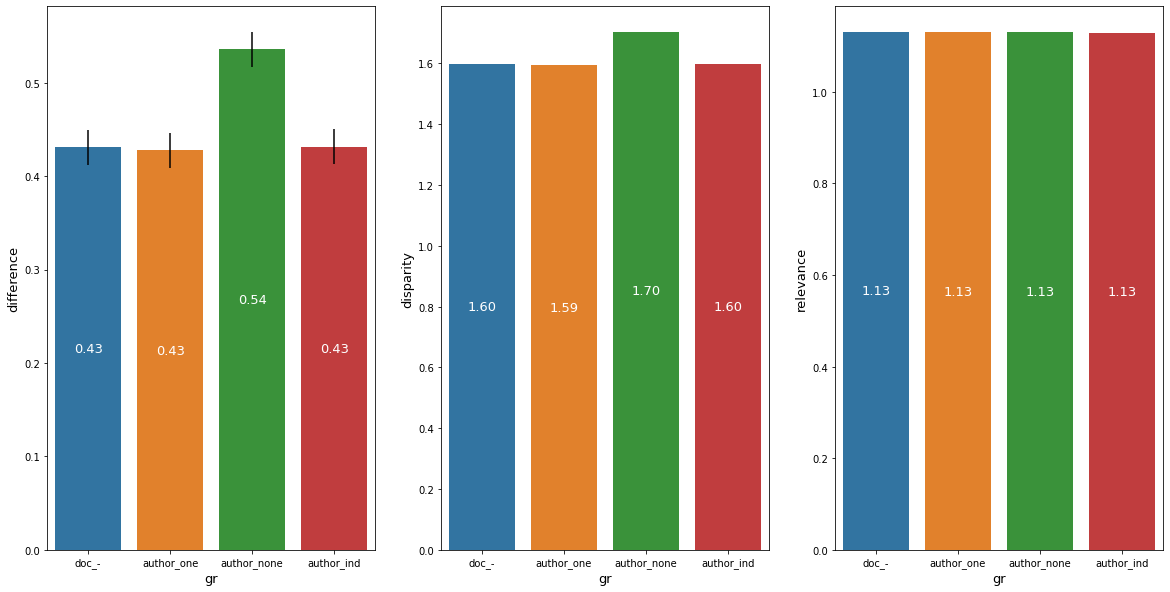

In [143]:
plt.rcParams["axes.labelsize"] = 13


ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups =  ackrdata.sort_values(by='gr',ascending=False).groupby('gr')
means = groups['difference'].mean()
m1 = means['doc_-']
n1 = len(groups.get_group('doc_-'))
m2 = means['author_one']
n2 = len(groups.get_group('author_one'))

m3 = means['author_none']
n3 = len(groups.get_group('author_none'))
m4 = means['author_ind']
n4 = len(groups.get_group('author_ind'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of $\mathtt{gr}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='gr', y='difference',ci=None, yerr=[c1,c2,c3,c4], data= ackrdata.sort_values(by='gr',ascending=False),ax=axs[0])
sns.barplot(x='gr', y='disparity', ci=None, data= ackrdata.sort_values(by='gr',ascending=False), ax=axs[1])
sns.barplot(x='gr', y='relevance', ci=None, data= ackrdata.sort_values(by='gr',ascending=False), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



In [144]:
formula = "difference_ind ~ C(gr) + C(theta) + C(hfunc) + C(qid)"
lm = ols(formula, ackrdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,1.64265,0.54755,52.20328,0.00000
C(theta),1.00000,0.10298,0.10298,9.81819,0.00178
C(hfunc),2.00000,0.20069,0.10035,9.56693,0.00008
C(qid),19.00000,48.21076,2.53741,241.91582,0.00000
Residual,934.00000,9.79655,0.01049,NaN,NaN


In [145]:
print_omegasq('gr',ackrdata)
print_omegasq('qid',ackrdata)

59.943145852713926
11.680440303154228
gr
omega-squared	omega-squared partial
0.02688			0.13794

59.943145852713926
58.080733192213316
qid
omega-squared	omega-squared partial
0.80095			0.82663



##### Tukey HSD

In [146]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ackrdata['difference_ind'], groups=ackrdata['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
 author_ind author_none   0.0933 0.001  0.0353  0.1513   True
 author_ind  author_one   0.0001   0.9 -0.0579  0.0582  False
 author_ind       doc_-  -0.0062   0.9 -0.0643  0.0518  False
author_none  author_one  -0.0932 0.001 -0.1512 -0.0352   True
author_none       doc_-  -0.0995 0.001 -0.1576 -0.0415   True
 author_one       doc_-  -0.0064   0.9 -0.0644  0.0517  False
-------------------------------------------------------------


In [148]:
ackrdata.groupby(['gr','theta','hfunc','qid']).count()

difference  disparity  relevance  difference_ind  \
gr         theta    hfunc  qid                                                        
author_ind 9.00000  linear 3462             2          2          2               2   
                           8940             2          2          2               2   
                           10795            2          2          2               2   
                           12073            2          2          2               2   
                           12096            2          2          2               2   
...                                       ...        ...        ...             ...   
doc_-      99.00000 min    64062            2          2          2               2   
                           66637            2          2          2               2   
                           67404            2          2          2               2   
                           70673            2          2          2               2   
                           120668           2          2          2               2   

                                   disparity_ind  relevance_ind  ranker  source  group  subgroup  \
gr         theta    hfunc  qid                                                                     
author_ind 9.00000  linear 3462                2              2       2       2      2         2   
                           8940                2              2       2       2      2         2   
                           10795               2              2       2       2      2         2   
                           12073               2              2       2       2      2         2   
                           12096               2              2       2       2      2         2   
...                                          ...            ...     ...     ...    ...       ...   
doc_-      99.00000 min    64062               2              2       2       2      2         2   
                           66637               2              2       2       2      2         2   
                           67404               2              2       2       2      2         2   
                           70673               2              2       2       2      2         2   
                           120668              2              2       2       2      2         2   

                                   augmentation  val_metric  feature_method  num_features  \
gr         theta    hfunc  qid                                                              
author_ind 9.00000  linear 3462               2           2               2             2   
                           8940               2           2               2             2   
                           10795              2           2               2             2   
                           12073              2           2               2             2   
                           12096              2           2               2             2   
...                                         ...         ...             ...           ...   
doc_-      99.00000 min    64062              2           2               2             2   
                           66637              2           2               2             2   
                           67404              2           2               2             2   
                           70673              2           2               2             2   
                           120668             2           2               2             2   

                                   balancing_factor  
gr         theta    hfunc  qid                       
author_ind 9.00000  linear 3462                   2  
                           8940                   2  
                           10795                  2  
                           12073                  2  
                           12096                  2  
...           

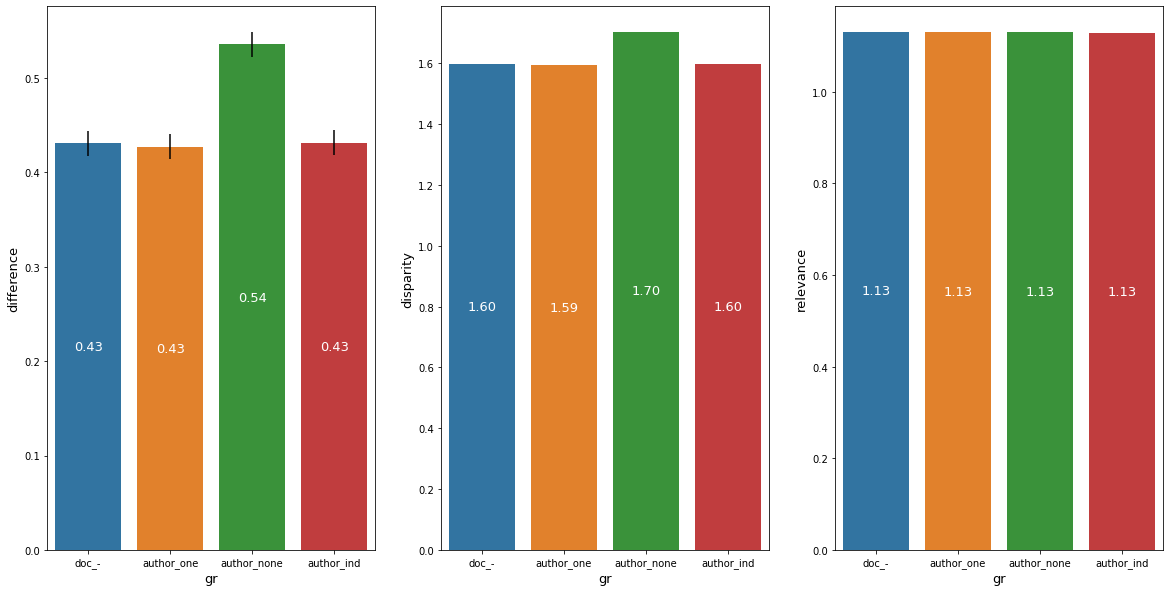

In [147]:
plt.rcParams["axes.labelsize"] = 13


ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups =  ackrdata.sort_values(by='gr',ascending=False).groupby('gr')
means = groups['difference_ind'].mean()
m1 = means['doc_-']
n1 = len(groups.get_group('doc_-'))
m2 = means['author_one']
n2 = len(groups.get_group('author_one'))

m3 = means['author_none']
n3 = len(groups.get_group('author_none'))
m4 = means['author_ind']
n4 = len(groups.get_group('author_ind'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of $\mathtt{gr}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='gr', y='difference',ci=None, yerr=[c1,c2,c3,c4], data= ackrdata.sort_values(by='gr',ascending=False),ax=axs[0])
sns.barplot(x='gr', y='disparity', ci=None, data= ackrdata.sort_values(by='gr',ascending=False), ax=axs[1])
sns.barplot(x='gr', y='relevance', ci=None, data= ackrdata.sort_values(by='gr',ascending=False), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



#### META

In [78]:
formula = "difference ~ C(gr) + C(theta) + C(hfunc) + C(qid)"
lm = ols(formula, ackrdata.query('source == "META_train"')).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.78479,0.26160,15.11130,0.00000
C(theta),1.00000,0.03034,0.03034,1.75258,0.18622
C(hfunc),2.00000,0.08485,0.04243,2.45076,0.08737
C(qid),19.00000,134.37045,7.07213,408.52572,0.00000
Residual,454.00000,7.85935,0.01731,NaN,NaN


In [79]:
ackrdata.query('source == "META_train"').drop('qid',axis=1).groupby('gr').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind
gr,,,,,,
author_ind,0.42549,1.59006,1.12888,0.46235,0.20247,0.14773
author_none,0.51796,1.68484,1.13004,0.54494,0.27127,0.14084
author_one,0.42280,1.58848,1.12944,0.46234,0.20359,0.14829
doc_-,0.42555,1.59146,1.12956,0.45648,0.19549,0.14718


In [80]:
ackrdata.query('source == "META_train"').drop('qid',axis=1).groupby('theta').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind
theta,,,,,,
9.00000,0.45590,1.62126,1.12928,0.49336,0.22774,0.14486
99.00000,0.44000,1.60616,1.12968,0.46970,0.20867,0.14716


In [81]:
ackrdata.query('source == "META_train"').drop('qid',axis=1).groupby('hfunc').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind
hfunc,,,,,,
linear,0.43584,1.58966,1.12351,0.45969,0.19676,0.14621
max,0.44154,1.62671,1.13918,0.48968,0.22986,0.14776
min,0.46646,1.62476,1.12575,0.49522,0.22800,0.14406


##### Effect sizes

In [82]:
print_omegasq('gr',ackrdata)
print_omegasq('qid',ackrdata)

143.11246640640144
17.35174568242543
gr
omega-squared	omega-squared partial
0.00512			0.04224

143.11246640640144
150.6604193356427
qid
omega-squared	omega-squared partial
0.93662			0.88969



##### Tukey HSD

In [83]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ackrdata.query('source == "META_train"')['difference'], groups=ackrdata.query('source == "META_train"')['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
 author_ind author_none   0.0925 0.5504 -0.0895 0.2745  False
 author_ind  author_one  -0.0027    0.9 -0.1847 0.1793  False
 author_ind       doc_-   0.0001    0.9  -0.182 0.1821  False
author_none  author_one  -0.0952 0.5291 -0.2772 0.0869  False
author_none       doc_-  -0.0924 0.5509 -0.2744 0.0896  False
 author_one       doc_-   0.0028    0.9 -0.1793 0.1848  False
-------------------------------------------------------------


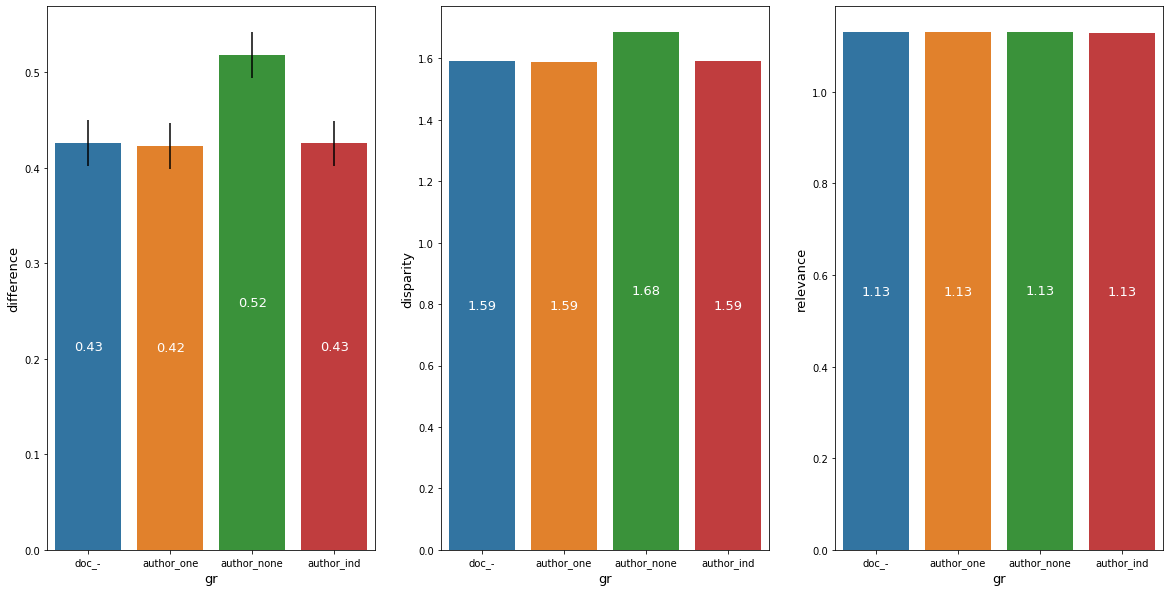

In [84]:
plt.rcParams["axes.labelsize"] = 13


ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups =  ackrdata.query('source == "META_train"').sort_values(by='gr',ascending=False).groupby('gr')
means = groups['difference'].mean()
m1 = means['doc_-']
n1 = len(groups.get_group('doc_-'))
m2 = means['author_one']
n2 = len(groups.get_group('author_one'))

m3 = means['author_none']
n3 = len(groups.get_group('author_none'))
m4 = means['author_ind']
n4 = len(groups.get_group('author_ind'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of $\mathtt{gr}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='gr', y='difference',ci=None, yerr=[c1,c2,c3,c4], data= ackrdata.query('source == "META_train"').sort_values(by='gr',ascending=False),ax=axs[0])
sns.barplot(x='gr', y='disparity', ci=None, data= ackrdata.query('source == "META_train"').sort_values(by='gr',ascending=False), ax=axs[1])
sns.barplot(x='gr', y='relevance', ci=None, data= ackrdata.query('source == "META_train"').sort_values(by='gr',ascending=False), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



#### TEXT

In [85]:
ackrdata.query('source == "TEXT_train"').drop('qid',axis=1).groupby('gr').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind
gr,,,,,,
author_ind,0.43782,1.60450,1.12994,0.47168,0.20139,0.14253
author_none,0.55320,1.72030,1.13015,0.57571,0.28853,0.13408
author_one,0.43209,1.60035,1.13073,0.47195,0.20312,0.14326
doc_-,0.43618,1.60544,1.13123,0.46509,0.19491,0.14258


In [86]:
ackrdata.query('source == "TEXT_train"').drop('qid',axis=1).groupby('theta').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind
theta,,,,,,
9.00000,0.47246,1.63838,1.12956,0.50499,0.22969,0.14002
99.00000,0.45719,1.62692,1.13147,0.48722,0.21429,0.14120


In [87]:
ackrdata.query('source == "TEXT_train"').drop('qid',axis=1).groupby('hfunc').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind
hfunc,,,,,,
linear,0.45518,1.61094,1.12448,0.47705,0.20214,0.14021
max,0.46213,1.64912,1.14010,0.50822,0.23590,0.14151
min,0.47716,1.63789,1.12696,0.50304,0.22792,0.14011


In [88]:
formula = "difference ~ C(gr) + C(theta) + C(hfunc) + C(qid)"
lm = ols(formula, ackrdata.query('source == "TEXT_train"')).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,1.25172,0.41724,18.29199,0.00000
C(theta),1.00000,0.02798,0.02798,1.22679,0.26862
C(hfunc),2.00000,0.04036,0.02018,0.88473,0.41354
C(qid),19.00000,147.64195,7.77063,340.66890,0.00000
Residual,454.00000,10.35570,0.02281,NaN,NaN


##### Effect sizes

In [89]:
print_omegasq('gr', ackrdata.query('source == "TEXT_train"'))
print_omegasq('qid', ackrdata.query('source == "TEXT_train"'))

159.29490122246324
12.132046089866694
gr
omega-squared	omega-squared partial
0.00743			0.09753

159.29490122246324
158.1573199972518
qid
omega-squared	omega-squared partial
0.92413			0.93077



##### Tukey HSD

In [90]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ackrdata.query('source == "TEXT_train"')['difference'], groups=ackrdata.query('source == "TEXT_train"')['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
 author_ind author_none   0.1154 0.4093 -0.0764 0.3072  False
 author_ind  author_one  -0.0057    0.9 -0.1975 0.1861  False
 author_ind       doc_-  -0.0016    0.9 -0.1934 0.1902  False
author_none  author_one  -0.1211 0.3646 -0.3129 0.0707  False
author_none       doc_-   -0.117 0.3964 -0.3088 0.0748  False
 author_one       doc_-   0.0041    0.9 -0.1877 0.1959  False
-------------------------------------------------------------


In [91]:
ackrdata.query('source == "TEXT_train"').groupby('gr').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
gr,,,,,,,
author_ind,0.43782,1.60450,1.12994,0.47168,0.20139,0.14253,39200.95000
author_none,0.55320,1.72030,1.13015,0.57571,0.28853,0.13408,39200.95000
author_one,0.43209,1.60035,1.13073,0.47195,0.20312,0.14326,39200.95000
doc_-,0.43618,1.60544,1.13123,0.46509,0.19491,0.14258,39200.95000


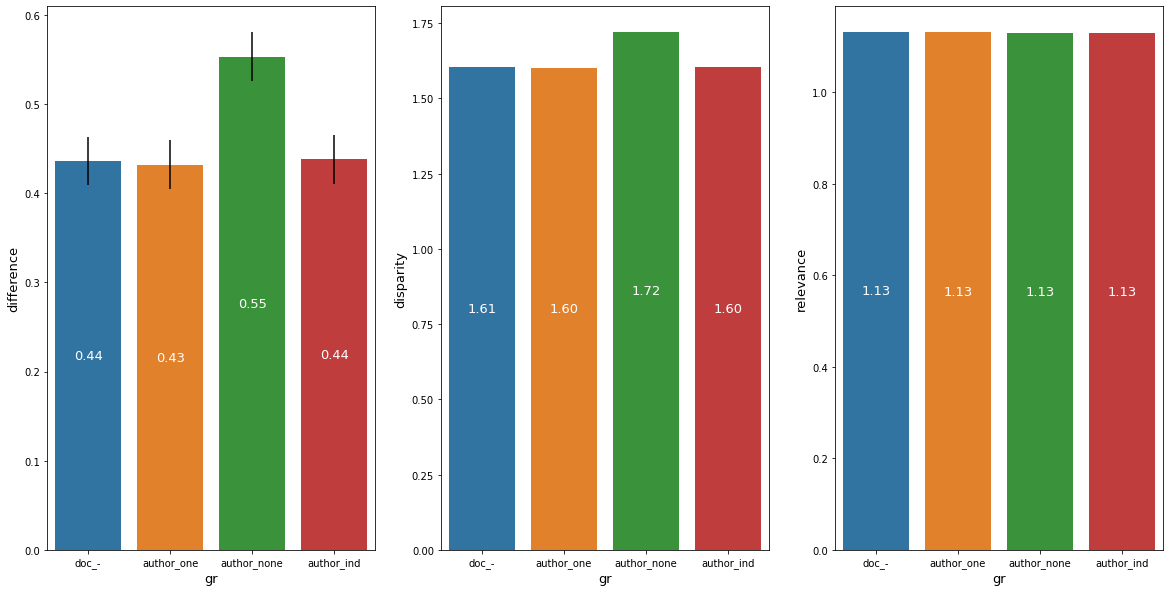

In [92]:
plt.rcParams["axes.labelsize"] = 13


ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups =  ackrdata.query('source == "TEXT_train"').sort_values(by='gr',ascending=False).groupby('gr')
means = groups['difference'].mean()
m1 = means['doc_-']
n1 = len(groups.get_group('doc_-'))
m2 = means['author_one']
n2 = len(groups.get_group('author_one'))

m3 = means['author_none']
n3 = len(groups.get_group('author_none'))
m4 = means['author_ind']
n4 = len(groups.get_group('author_ind'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of $\mathtt{gr}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='gr', y='difference',ci=None, yerr=[c1,c2,c3,c4], data= ackrdata.query('source == "TEXT_train"').sort_values(by='gr',ascending=False),ax=axs[0])
sns.barplot(x='gr', y='disparity', ci=None, data= ackrdata.query('source == "TEXT_train"').sort_values(by='gr',ascending=False), ax=axs[1])
sns.barplot(x='gr', y='relevance', ci=None, data= ackrdata.query('source == "TEXT_train"').sort_values(by='gr',ascending=False), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



### EEL_ind

In [106]:
formula = "difference_ind ~ C(source) + C(gr) + C(theta) + C(hfunc) + C(qid)"
lm = ols(formula, ackrdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(source),1.00000,0.05102,0.05102,4.88417,0.02735
C(gr),3.00000,1.64265,0.54755,52.42037,0.00000
C(theta),1.00000,0.10298,0.10298,9.85902,0.00174
C(hfunc),2.00000,0.20069,0.10035,9.60672,0.00007
C(qid),19.00000,48.21076,2.53741,242.92186,0.00000
Residual,933.00000,9.74553,0.01045,NaN,NaN


#### META

In [107]:
formula = "difference_ind ~ C(gr) + C(theta) + C(hfunc) + C(qid)"
lm = ols(formula, ackrdata.query('source == "META_train"')).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.64610,0.21537,23.32619,0.00000
C(theta),1.00000,0.06718,0.06718,7.27665,0.00725
C(hfunc),2.00000,0.11695,0.05847,6.33318,0.00194
C(qid),19.00000,22.36422,1.17706,127.48716,0.00000
Residual,454.00000,4.19169,0.00923,NaN,NaN


##### Effect sizes

In [108]:
print_omegasq('gr', ackrdata.query('source == "META_train"'))
print_omegasq('theta', ackrdata.query('source == "META_train"'))
print_omegasq('hfunc', ackrdata.query('source == "META_train"'))
print_omegasq('qid', ackrdata.query('source == "META_train"'))

27.376908144111077
5.05014687129976
gr
omega-squared	omega-squared partial
0.02259			0.12245

27.376908144111077
4.48969784531036
theta
omega-squared	omega-squared partial
0.00212			0.01291

27.376908144111077
4.530227242405628
hfunc
omega-squared	omega-squared partial
0.0036			0.02174

27.376908144111077
26.620542064060835
qid
omega-squared	omega-squared partial
0.81049			0.83352



##### Tukey HSD

In [109]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ackrdata.query('source == "META_train"')['difference_ind'], groups=ackrdata.query('source == "META_train"')['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
 author_ind author_none   0.0826 0.0361  0.0037  0.1615   True
 author_ind  author_one     -0.0    0.9 -0.0789  0.0789  False
 author_ind       doc_-  -0.0059    0.9 -0.0848   0.073  False
author_none  author_one  -0.0826 0.0361 -0.1615 -0.0037   True
author_none       doc_-  -0.0885 0.0209 -0.1673 -0.0096   True
 author_one       doc_-  -0.0059    0.9 -0.0847   0.073  False
--------------------------------------------------------------


In [110]:
ackrdata.query('source == "META_train"').groupby('gr').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
gr,,,,,,,
author_ind,0.42549,1.59006,1.12888,0.46235,0.20247,0.14773,39200.95000
author_none,0.51796,1.68484,1.13004,0.54494,0.27127,0.14084,39200.95000
author_one,0.42280,1.58848,1.12944,0.46234,0.20359,0.14829,39200.95000
doc_-,0.42555,1.59146,1.12956,0.45648,0.19549,0.14718,39200.95000


In [111]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ackrdata.query('source == "META_train"')['difference_ind'], groups=ackrdata.query('source == "META_train"')['theta'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   9.0   99.0  -0.0237 0.2788 -0.0665 0.0192  False
---------------------------------------------------


In [112]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ackrdata.query('source == "META_train"')['difference_ind'], groups=ackrdata.query('source == "META_train"')['hfunc'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
linear    max     0.03 0.502 -0.0329 0.0928  False
linear    min   0.0355 0.381 -0.0273 0.0984  False
   max    min   0.0055   0.9 -0.0573 0.0684  False
--------------------------------------------------


##### Tukey effect size

In [113]:
means = ackrdata.query('source == "META_train"').groupby('gr')['difference_ind'].mean()
m1 = means['doc_-']
m2 = means['author_none']
m3 = means['author_ind']
m4 = means['author_one']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(round(cohens_d(m1, m2, ms_error),2)) # doc vs none
print(round(cohens_d(m3, m2, ms_error),2)) # none ind
print(round(cohens_d(m4, m2, ms_error),2)) # one none


0.92
0.86
0.86


##### Visualize performance in terms of difference, disparity, relevance + error bars


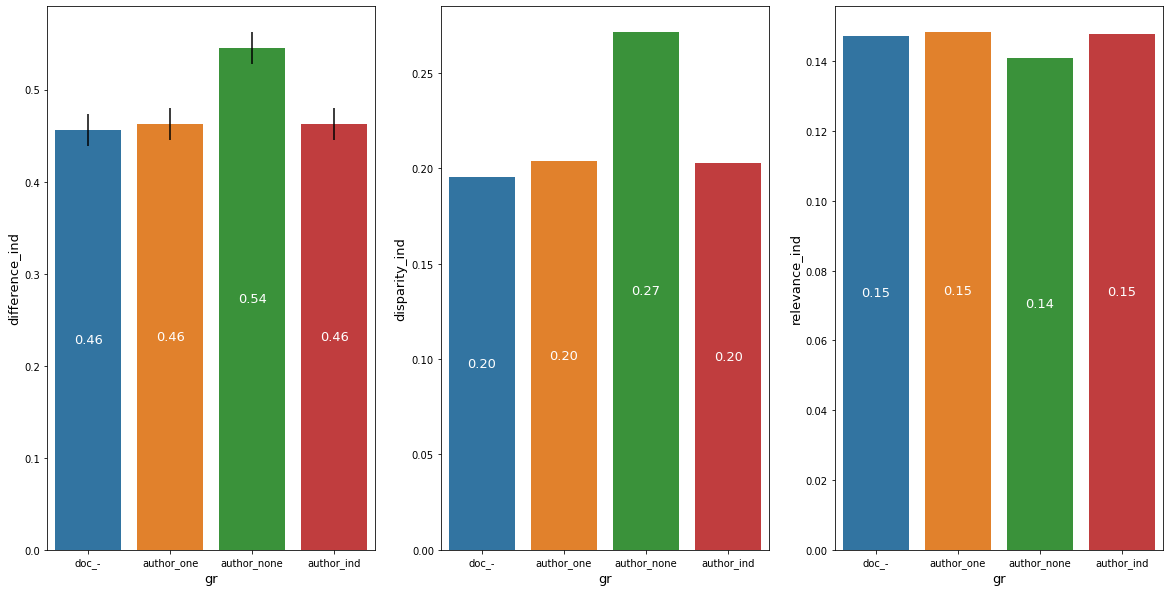

In [114]:
plt.rcParams["axes.labelsize"] = 13


ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups =  ackrdata.query('source == "META_train"').sort_values(by='gr',ascending=False).groupby('gr')
means = groups['difference_ind'].mean()
m1 = means['doc_-']
n1 = len(groups.get_group('doc_-'))
m2 = means['author_one']
n2 = len(groups.get_group('author_one'))

m3 = means['author_none']
n3 = len(groups.get_group('author_none'))
m4 = means['author_ind']
n4 = len(groups.get_group('author_ind'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of $\mathtt{gr}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='gr', y='difference_ind',ci=None, yerr=[c1,c2,c3,c4], data= ackrdata.query('source == "META_train"').sort_values(by='gr',ascending=False),ax=axs[0])
sns.barplot(x='gr', y='disparity_ind', ci=None, data= ackrdata.query('source == "META_train"').sort_values(by='gr',ascending=False), ax=axs[1])
sns.barplot(x='gr', y='relevance_ind', ci=None, data= ackrdata.query('source == "META_train"').sort_values(by='gr',ascending=False), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



#### TEXT

In [115]:
formula = "difference_ind ~ C(gr) + C(theta) + C(hfunc) + C(qid)"
lm = ols(formula, ackrdata.query('source == "TEXT_train"')).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,1.01757,0.33919,28.88819,0.00000
C(theta),1.00000,0.03788,0.03788,3.22631,0.07313
C(hfunc),2.00000,0.08927,0.04464,3.80153,0.02305
C(qid),19.00000,26.04114,1.37059,116.73060,0.00000
Residual,454.00000,5.33062,0.01174,NaN,NaN


##### Effect sizes

In [116]:
print_omegasq('gr', ackrdata.query('source == "TEXT_train"'))
print_omegasq('hfunc', ackrdata.query('source == "TEXT_train"'))
print_omegasq('qid', ackrdata.query('source == "TEXT_train"'))

32.504735312348046
6.618238146928737
gr
omega-squared	omega-squared partial
0.03022			0.14843

32.504735312348046
5.701683039648024
hfunc
omega-squared	omega-squared partial
0.00202			0.01154

32.504735312348046
31.453947026474864
qid
omega-squared	omega-squared partial
0.79429			0.82082



##### Tukey HSD

In [117]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ackrdata.query('source == "TEXT_train"')['difference_ind'], groups=ackrdata.query('source == "TEXT_train"')['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
 author_ind author_none    0.104 0.0099  0.0184  0.1897   True
 author_ind  author_one   0.0003    0.9 -0.0854  0.0859  False
 author_ind       doc_-  -0.0066    0.9 -0.0922   0.079  False
author_none  author_one  -0.1038 0.0102 -0.1894 -0.0181   True
author_none       doc_-  -0.1106 0.0051 -0.1962  -0.025   True
 author_one       doc_-  -0.0069    0.9 -0.0925  0.0788  False
--------------------------------------------------------------


In [118]:
ackrdata.query('source == "TEXT_train"').groupby('gr').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
gr,,,,,,,
author_ind,0.43782,1.60450,1.12994,0.47168,0.20139,0.14253,39200.95000
author_none,0.55320,1.72030,1.13015,0.57571,0.28853,0.13408,39200.95000
author_one,0.43209,1.60035,1.13073,0.47195,0.20312,0.14326,39200.95000
doc_-,0.43618,1.60544,1.13123,0.46509,0.19491,0.14258,39200.95000


In [119]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ackrdata.query('source == "TEXT_train"')['difference_ind'], groups=ackrdata.query('source == "TEXT_train"')['hfunc'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
linear    max   0.0312 0.5323 -0.0374 0.0997  False
linear    min    0.026 0.6339 -0.0425 0.0945  False
   max    min  -0.0052    0.9 -0.0737 0.0634  False
---------------------------------------------------


##### Tukey effect size

In [120]:
means = ackrdata.query('source == "TEXT_train"').groupby('gr')['difference_ind'].mean()
m1 = means['doc_-']
m2 = means['author_none']
m3 = means['author_ind']
m4 = means['author_one']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(round(cohens_d(m1, m2, ms_error),2)) # none doc
print(round(cohens_d(m3, m2, ms_error),2)) # none ind
print(round(cohens_d(m4, m2, ms_error),2)) # none one


1.02
0.96
0.96


##### Visualize performance in terms of difference, disparity, relevance + error bars


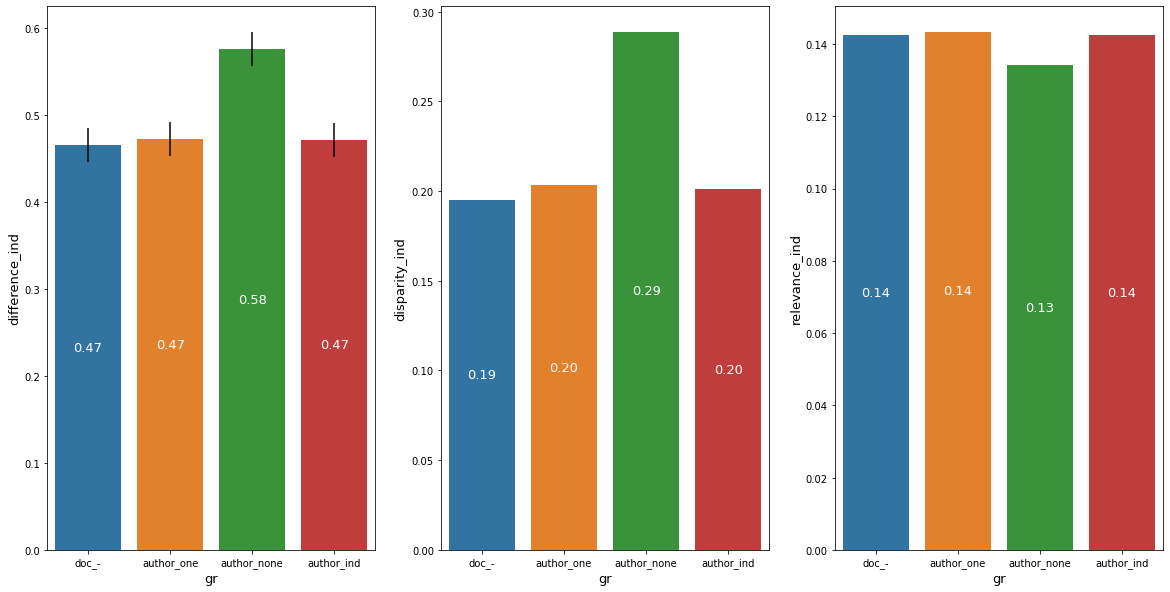

In [121]:
plt.rcParams["axes.labelsize"] = 13


ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups =  ackrdata.query('source == "TEXT_train"').sort_values(by='gr',ascending=False).groupby('gr')
means = groups['difference_ind'].mean()
m1 = means['doc_-']
n1 = len(groups.get_group('doc_-'))
m2 = means['author_one']
n2 = len(groups.get_group('author_one'))

m3 = means['author_none']
n3 = len(groups.get_group('author_none'))
m4 = means['author_ind']
n4 = len(groups.get_group('author_ind'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of $\mathtt{gr}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='gr', y='difference_ind',ci=None, yerr=[c1,c2,c3,c4], data= ackrdata.query('source == "TEXT_train"').sort_values(by='gr',ascending=False),ax=axs[0])
sns.barplot(x='gr', y='disparity_ind', ci=None, data= ackrdata.query('source == "TEXT_train"').sort_values(by='gr',ascending=False), ax=axs[1])
sns.barplot(x='gr', y='relevance_ind', ci=None, data= ackrdata.query('source == "TEXT_train"').sort_values(by='gr',ascending=False), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



## Are the values of the base versions of AC improved by our changes (merged sets)?

### Select data

In [216]:
ackrdata = experiments.query('ranker == "ac" and (source == "TEXT_train" or source == "META_train")')
ackrdata = ackrdata.reset_index(drop=True)

ackrdata

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.09151,1.73020,1.37603,0.40510,0.11638,0.07613,3462,ac,META_train,author,ind,99.00000,linear,-,-,-,-,-,author_ind
1,0.34400,1.36933,0.95825,0.56015,0.30825,0.26554,8940,ac,META_train,author,ind,99.00000,linear,-,-,-,-,-,author_ind
2,0.11141,1.77696,1.43747,0.31003,0.11223,0.07853,10795,ac,META_train,author,ind,99.00000,linear,-,-,-,-,-,author_ind
3,0.11426,1.09435,0.82062,0.14962,0.09688,0.05444,12073,ac,META_train,author,ind,99.00000,linear,-,-,-,-,-,author_ind
4,0.27833,1.33008,1.39215,0.66967,0.18819,0.15030,12096,ac,META_train,author,ind,99.00000,linear,-,-,-,-,-,author_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,0.27267,2.23038,1.53659,0.34305,0.16840,0.13317,64062,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-,doc_-
956,0.11407,2.82126,2.27971,0.58871,0.30796,0.25111,66637,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-,doc_-
957,0.30607,1.41376,1.40719,0.56222,0.30336,0.26206,67404,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-,doc_-
958,0.44303,1.82916,1.15587,0.68086,0.21450,0.15797,70673,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-,doc_-


In [234]:
ackrdata.groupby('theta').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
theta,,,,,,,
9.00000,0.46418,1.62982,1.12942,0.49918,0.22871,0.14244,39200.95000
99.00000,0.44859,1.61654,1.13057,0.47846,0.21148,0.14418,39200.95000


In [236]:
ackrdata.groupby('gr').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
gr,,,,,,,
author_ind,0.43165,1.59728,1.12941,0.46701,0.20193,0.14513,39200.95000
author_none,0.53558,1.70257,1.13009,0.56033,0.27990,0.13746,39200.95000
author_one,0.42744,1.59442,1.13008,0.46714,0.20336,0.14578,39200.95000
doc_-,0.43087,1.59845,1.13039,0.46079,0.19520,0.14488,39200.95000


In [217]:
ackrdata.source.value_counts()

META_train    480
TEXT_train    480
Name: source, dtype: int64

In [218]:
ackrdata.theta.value_counts()

99.00000    480
9.00000     480
Name: theta, dtype: int64

In [219]:
ackrdata.hfunc.value_counts()

linear    320
max       320
min       320
Name: hfunc, dtype: int64

In [220]:
ackrdata.gr.value_counts()

author_ind     240
author_none    240
author_one     240
doc_-          240
Name: gr, dtype: int64

### EEL

In [221]:
formula = "difference ~ C(gr) + C(theta) + C(hfunc) + C(qid)"
lm = ols(formula, ackrdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,2.00924,0.66975,31.82754,0.00000
C(theta),1.00000,0.05830,0.05830,2.77045,0.09635
C(hfunc),2.00000,0.12057,0.06028,2.86478,0.05750
C(qid),19.00000,280.67354,14.77229,702.00396,0.00000
Residual,934.00000,19.65419,0.02104,NaN,NaN


In [222]:
print_omegasq('gr',ackrdata)
print_omegasq('qid',ackrdata)

302.494800962281
22.147425181169044
gr
omega-squared	omega-squared partial
0.00643			0.08787

302.494800962281
300.47503562381416
qid
omega-squared	omega-squared partial
0.92654			0.93277



##### Tukey HSD

In [223]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ackrdata['difference'], groups=ackrdata['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
 author_ind author_none   0.1039 0.1774 -0.0278 0.2356  False
 author_ind  author_one  -0.0042    0.9 -0.1359 0.1275  False
 author_ind       doc_-  -0.0008    0.9 -0.1325 0.1309  False
author_none  author_one  -0.1081 0.1498 -0.2399 0.0236  False
author_none       doc_-  -0.1047 0.1722 -0.2364  0.027  False
 author_one       doc_-   0.0034    0.9 -0.1283 0.1351  False
-------------------------------------------------------------


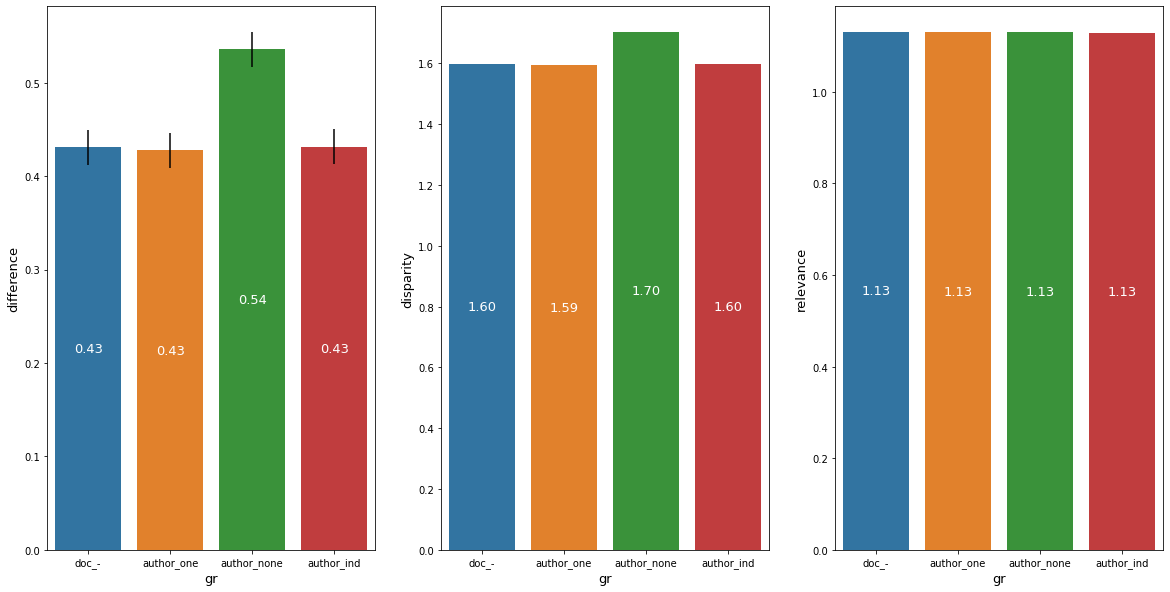

In [224]:
plt.rcParams["axes.labelsize"] = 13


ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups =  ackrdata.sort_values(by='gr',ascending=False).groupby('gr')
means = groups['difference'].mean()
m1 = means['doc_-']
n1 = len(groups.get_group('doc_-'))
m2 = means['author_one']
n2 = len(groups.get_group('author_one'))

m3 = means['author_none']
n3 = len(groups.get_group('author_none'))
m4 = means['author_ind']
n4 = len(groups.get_group('author_ind'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of $\mathtt{gr}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='gr', y='difference',ci=None, yerr=[c1,c2,c3,c4], data= ackrdata.sort_values(by='gr',ascending=False),ax=axs[0])
sns.barplot(x='gr', y='disparity', ci=None, data= ackrdata.sort_values(by='gr',ascending=False), ax=axs[1])
sns.barplot(x='gr', y='relevance', ci=None, data= ackrdata.sort_values(by='gr',ascending=False), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



In [225]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ackrdata['difference_ind'], groups=ackrdata['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
 author_ind author_none   0.0933 0.001  0.0353  0.1513   True
 author_ind  author_one   0.0001   0.9 -0.0579  0.0582  False
 author_ind       doc_-  -0.0062   0.9 -0.0643  0.0518  False
author_none  author_one  -0.0932 0.001 -0.1512 -0.0352   True
author_none       doc_-  -0.0995 0.001 -0.1576 -0.0415   True
 author_one       doc_-  -0.0064   0.9 -0.0644  0.0517  False
-------------------------------------------------------------


### EEL_ind

In [226]:
formula = "difference_ind ~ C(gr) + C(theta) + C(hfunc) + C(qid)"
lm = ols(formula, ackrdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,1.64265,0.54755,52.20328,0.00000
C(theta),1.00000,0.10298,0.10298,9.81819,0.00178
C(hfunc),2.00000,0.20069,0.10035,9.56693,0.00008
C(qid),19.00000,48.21076,2.53741,241.91582,0.00000
Residual,934.00000,9.79655,0.01049,NaN,NaN


##### Effect sizes

In [227]:
print_omegasq('gr', ackrdata)
print_omegasq('theta', ackrdata)
print_omegasq('hfunc', ackrdata)
print_omegasq('qid', ackrdata)

59.943145852713926
11.680440303154228
gr
omega-squared	omega-squared partial
0.02688			0.13794

59.943145852713926
10.161748415223663
theta
omega-squared	omega-squared partial
0.00154			0.0091

59.943145852713926
10.248969989272714
hfunc
omega-squared	omega-squared partial
0.003			0.01753

59.943145852713926
58.080733192213316
qid
omega-squared	omega-squared partial
0.80095			0.82663



##### Tukey HSD

In [228]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ackrdata['difference_ind'], groups=ackrdata['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
 author_ind author_none   0.0933 0.001  0.0353  0.1513   True
 author_ind  author_one   0.0001   0.9 -0.0579  0.0582  False
 author_ind       doc_-  -0.0062   0.9 -0.0643  0.0518  False
author_none  author_one  -0.0932 0.001 -0.1512 -0.0352   True
author_none       doc_-  -0.0995 0.001 -0.1576 -0.0415   True
 author_one       doc_-  -0.0064   0.9 -0.0644  0.0517  False
-------------------------------------------------------------


In [229]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ackrdata['difference_ind'], groups=ackrdata['theta'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   9.0   99.0  -0.0207 0.1995 -0.0524 0.0109  False
---------------------------------------------------


In [230]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ackrdata['difference_ind'], groups=ackrdata['hfunc'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
linear    max   0.0306 0.2694 -0.0158  0.077  False
linear    min   0.0308 0.2653 -0.0156 0.0771  False
   max    min   0.0002    0.9 -0.0462 0.0465  False
---------------------------------------------------


##### Tukey effect size

In [231]:
means = ackrdata.groupby('gr')['difference_ind'].mean()
m1 = means['doc_-']
m2 = means['author_none']
m3 = means['author_ind']
m4 = means['author_one']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(round(cohens_d(m1, m2, ms_error),2)) # doc vs none
print(round(cohens_d(m3, m2, ms_error),2)) # none ind
print(round(cohens_d(m4, m2, ms_error),2)) # one none


0.97
0.91
0.91


##### Visualize performance in terms of difference, disparity, relevance + error bars


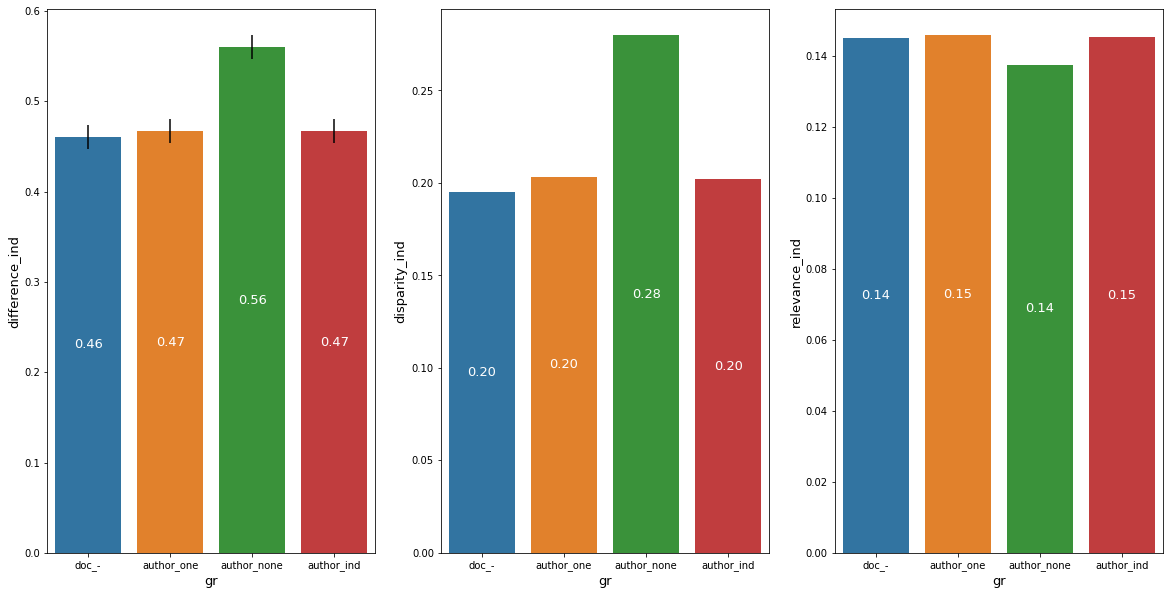

In [232]:
plt.rcParams["axes.labelsize"] = 13


ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = ackrdata.sort_values(by='gr',ascending=False).groupby('gr')
means = groups['difference_ind'].mean()
m1 = means['doc_-']
n1 = len(groups.get_group('doc_-'))
m2 = means['author_one']
n2 = len(groups.get_group('author_one'))

m3 = means['author_none']
n3 = len(groups.get_group('author_none'))
m4 = means['author_ind']
n4 = len(groups.get_group('author_ind'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

# _ = fig.suptitle(r'Comparison of the levels of $\mathtt{gr}$ in terms of EEL$_{ind}$, EEL-D$_{ind}$, and EEL-R$_{ind}$', fontsize = 15)

sns.barplot(x='gr', y='difference_ind',ci=None, yerr=[c1,c2,c3,c4], data= ackrdata.sort_values(by='gr',ascending=False),ax=axs[0])
sns.barplot(x='gr', y='disparity_ind', ci=None, data= ackrdata.sort_values(by='gr',ascending=False), ax=axs[1])
sns.barplot(x='gr', y='relevance_ind', ci=None, data= ackrdata.sort_values(by='gr',ascending=False), ax=axs[2])



_ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
_ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)



# BAAKJSALSJDFLKJS

### effect size methods

In [149]:
def omega_squared(ms_effect, ms_error, df_effect, ss_total, roundd=True):
    wsq = (df_effect * (ms_effect - ms_error)) / (ss_total - ms_error)
    if roundd:
        return round(wsq,5)
    return wsq
    

In [150]:
def omega_squared_partial(ms_effect, ms_error, df_effect, total_observations, roundd=True):
    wsqp = (df_effect * (ms_effect - ms_error)) / (df_effect * ms_effect + (total_observations - df_effect) * ms_error)
    if roundd:
        return round(wsqp,5)
    return wsqp

In [151]:
def eta_squared(ss_effect, ss_total, roundd=True):
    if roundd:
        return round(ss_effect/ss_total,5)
    else:
        return ss_effect/ss_total

In [152]:
def eta_squared_partial(ss_effect, ss_error, roundd=True):
    if roundd:
        return round(ss_effect/(ss_effect + ss_error),5)
    else:
        return ss_effect/(ss_effect + ss_error)

In [153]:
def cohens_d(m1, m2, ms_error):
    return abs(m1 - m2) / math.sqrt(ms_error)

In [154]:
def ci(m, num_observations, ms_error):
    t = stats.t.ppf(1-0.025, num_observations)
    return t*math.sqrt(ms_error/num_observations)

In [155]:
def print_etasq(factor):
    ss_effect = anova_lm(lm).sum_sq.loc[f'C({factor})']
    ss_error = anova_lm(lm).sum_sq.loc['Residual']
    ss_total = anova_lm(lm).sum_sq.sum()

    print(factor)
    
    print(f"eta-squared\teta-squared partial")
    print(f"{eta_squared(ss_effect, ss_total)}\t\t\t{eta_squared_partial(ss_effect, ss_error)}")
    print()

In [156]:
def print_omegasq(factor, data, roundd=True):
    ms_effect = anova_lm(lm).mean_sq.loc[f'C({factor})']
    ms_error = anova_lm(lm).mean_sq.loc['Residual']
    df_effect = anova_lm(lm).df.loc[f'C({factor})']
    ss_total = anova_lm(lm).sum_sq.sum()
    N = len(data)
    
    print(ss_total - ms_error)
    print(df_effect * ms_effect + (N - df_effect) * ms_error)
    
    print(factor)
    
    print(f"omega-squared\tomega-squared partial")
    print(f"{omega_squared(ms_effect, ms_error, df_effect, ss_total,roundd)}\t\t\t{omega_squared_partial(ms_effect, ms_error, df_effect, N,roundd)}")
    print()

In [157]:
def effect_size_t_test(a,b,roundd=2):
    differences = a - b
    sample_mean = differences.sum()/len(differences)
    sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences - 1)
    return round(abs(sample_mean) / math.sqrt(sample_variance),roundd)

In [160]:
experiments

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,3462,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,8940,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,10795,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,12073,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,12096,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67275,0.34180,2.19984,1.48675,0.85813,1.08333,0.33309,64062,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-
67276,0.32117,3.71522,2.62314,1.88697,1.32937,0.11269,66637,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-
67277,0.01885,2.07322,1.88053,0.52595,1.08236,0.66969,67404,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-
67278,1.01241,2.37717,1.14519,2.08095,1.33333,0.01734,70673,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-


In [190]:
a - b

0     0.01851
1    -0.00694
2     0.00014
3     0.32763
4    -1.41871
5     0.16332
6     1.30270
7     0.00001
8    -0.00889
9     0.95549
10   -0.00741
11    0.72747
12    0.02249
13    0.42637
14    0.11535
15    0.00000
16   -0.00198
17    0.01105
18   -0.22455
19    0.00000
Name: difference, dtype: float64

In [192]:
(a - b).sum()/20

0.12010225000000005

In [183]:
a = experiments.query('ranker ==  "relevance_ranker" and source == "TEXT"')['difference'].reset_index(drop=True)
b = experiments.query('ranker ==  "relevance_ranker" and source == "META"')['difference'].reset_index(drop=True)

In [163]:
stats.ttest_rel(a, b)

Ttest_relResult(statistic=1.0223654678620604, pvalue=0.3194497273969435)

The difference in scores is significant, p = 0.00000 < 0.05.

In [164]:
effect_size_t_test(a, b,roundd=3)

0.235

In [165]:
differences = a - b
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences - 1)

In [166]:
c = ci(sample_mean,len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,2), round(ch,2)

(-0.12, 0.36)

In [167]:
round(sample_mean,3)

0.12

In [168]:
round(sample_variance,2)

0.26

In [176]:
a = experiments.query('ranker ==  "relevance_ranker" and source == "TEXT"')['difference_ind'].reset_index(drop=True)
b = experiments.query('ranker ==  "relevance_ranker" and source == "META"')['difference_ind'].reset_index(drop=True)

In [177]:
stats.ttest_rel(a, b)

Ttest_relResult(statistic=-0.4018339037982424, pvalue=0.6922904359566049)

The difference in scores is significant, p = 0.00000 < 0.05.

In [178]:
effect_size_t_test(a, b,roundd=3)

0.092

In [179]:
differences = a - b
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences - 1)

In [180]:
c = ci(sample_mean,len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,2), round(ch,2)

(-0.13, 0.09)

In [181]:
round(sample_mean,3)

-0.021

In [182]:
round(sample_variance,3)

0.052

## Which pipeline configuration yields the best result? Which factors make it so?

Since the base LM config (NDCG, no augmentation, no feature selection) yields the highest fairness both for group and individual fairness, we use it as the base configuration for re-ranking.

Now we see if re-ranking significantly improves the eel and eel ind.

### ANOVA without replication main factors

In [ ]:
pipeline = experiments.copy()
# pipeline = experiments[((experiments.ranker == 'ac') | (experiments.ranker == 'rfr') | (experiments.ranker == 'lambdamart'))]
pipeline.source = pipeline.source.apply(lambda row: 'lm_err' if 'err' in row else 'lm_ndcg' if 'ndcg' in row else 'KR' if 'train' in row else row)
pipeline['gr'] = pipeline.apply(lambda df: '_'.join([df.group, df.subgroup]),axis=1)
pipeline = pipeline.reset_index(drop=True)


pipeline

## group EEL

In [ ]:
formula = "difference ~ C(ranker) + C(qid)"
lm = ols(formula, pipeline).fit()
lm.summary()
anova_lm(lm)

#### ANOVA effect sizes

In [ ]:
print_omegasq('ranker')

#### Tukey HSD

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=pipeline['difference'], groups=pipeline['ranker'], alpha=0.05)
print(tukey)


#### cohen's d

In [ ]:
pipeline.groupby('ranker')['difference'].mean()

In [ ]:
# val_metric
means = pipeline.groupby('ranker')['difference'].mean()
m1 = means['lambdamart']
m2 = means['ac']
m3 = means['rfr']
m4 = means['relevance_ranker']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m1, m4, ms_error))
print(cohens_d(m2, m3, ms_error))
print(cohens_d(m2, m4, ms_error))
print(cohens_d(m3, m4, ms_error))

#### Visualize performance in term of difference, disparity, relevance + bar charts

In [ ]:
print(len(experiments))
len(experiments.drop_duplicates())


In [ ]:
pipeline.groupby('ranker')[['difference','disparity','relevance']].mean()

In [ ]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = pipeline.groupby('ranker')
means = groups['difference'].mean()
m1 = means['ac']
n1 = len(groups.get_group('ac'))
m2 = means['lambdamart']
n2 = len(groups.get_group('lambdamart'))
m3 = means['rfr']
n3 = len(groups.get_group('rfr'))
m4 = means['relevance_ranker']
n4 = len(groups.get_group('relevance_ranker'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='ranker', y='difference',ci=None, yerr=[c1,c2,c3,c4], data=pipeline,ax=axs[0])
sns.barplot(x='ranker', y='disparity', ci=None, data=pipeline, ax=axs[1])
sns.barplot(x='ranker', y='relevance', ci=None, data=pipeline, ax=axs[2])


## within AC and RFR

#### AC

In [ ]:
acdata[acdata.source.str.contains('lm')].groupby('source').mean()

In [ ]:
acdata = pipeline[(pipeline.ranker == 'ac')]

# acdata.source = acdata.source.apply(lambda x: 'KR' if '_train' in x else 'lambdamart')
acdata = acdata.reset_index(drop=True)
acdata
# acdata.tail()

In [ ]:
formula = 'difference ~ C(gr) + C(theta) + C(hfunc) + C(source) + C(qid)'
lm = ols(formula, acdata).fit()
lm.summary()
anova_lm(lm)

#### ANOVA effect sizes

In [ ]:
print_omegasq('gr')
print_omegasq('hfunc')
print_omegasq('source')

#### Tukey HSD

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference'], groups=acdata['gr'], alpha=0.05)
print(tukey)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference'], groups=acdata['source'], alpha=0.05)
print(tukey)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference'], groups=acdata['hfunc'], alpha=0.05)
print(tukey)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference'], groups=acdata['theta'], alpha=0.05)
print(tukey)


#### cohen's d

In [ ]:
# val_metric
means = acdata.groupby('gr')['difference'].mean()
m1 = means['auth_ind']
m2 = means['auth_none']
m3 = means['auth_one']
m4 = means['doc_-']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m4, ms_error))
print(cohens_d(m2, m3, ms_error))
print(cohens_d(m2, m4, ms_error))
print(cohens_d(m3, m4, ms_error))



#### Visualize performance in term of difference, disparity, relevance + bar charts

In [ ]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('gr')
means = groups['difference'].mean()
m2 = means['auth_none']
n2 = len(groups.get_group('auth_none'))
m1 = means['auth_ind']
n1 = len(groups.get_group('auth_ind'))
m3 = means['auth_one']
n3 = len(groups.get_group('auth_one'))
m4 = means['doc_-']
n4 = len(groups.get_group('doc_-'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='gr', y='difference',ci=None, yerr=[c1,c2,c3,c4], data=acdata,ax=axs[0])
sns.barplot(x='gr', y='disparity', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='gr', y='relevance', ci=None, data=acdata, ax=axs[2])


In [ ]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('source')
means = groups['difference'].mean()
m3 = means['KR']
n3 = len(groups.get_group('KR'))
m1 = means['lm_err']
n1 = len(groups.get_group('lm_err'))
m2 = means['lm_ndcg']
n2 = len(groups.get_group('lm_ndcg'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference',ci=None, yerr=[c1,c2,c3], data=acdata,ax=axs[0])
sns.barplot(x='source', y='disparity', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='source', y='relevance', ci=None, data=acdata, ax=axs[2])


## RFR

In [ ]:
rfrdata = pipeline[(pipeline.ranker == 'rfr')]

# acdata.source = acdata.source.apply(lambda x: 'KR' if '_train' in x else 'lambdamart')
rfrdata = rfrdata.reset_index(drop=True)
rfrdata
# acdata.tail()

In [ ]:
formula = 'difference ~ C(gr) + C(source) + C(qid)'
lm = ols(formula, rfrdata).fit()
lm.summary()
anova_lm(lm)

#### ANOVA effect sizes

In [ ]:
print_omegasq('gr')
print_omegasq('source')

#### Tukey HSD

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=rfrdata['difference'], groups=rfrdata['gr'], alpha=0.05)
print(tukey)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=rfrdata['difference'], groups=rfrdata['source'], alpha=0.05)
print(tukey)


#### cohen's d

In [ ]:
rfrdata.groupby('source')['difference'].mean()

In [ ]:
# val_metric
means = rfrdata.groupby('gr')['difference'].mean()
m1 = means['auth_none']
m2 = means['auth_one']
m3 = means['auth_ind']
m4 = means['doc_-']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m1, m4, ms_error))
print(cohens_d(m2, m3, ms_error))
print(cohens_d(m2, m4, ms_error))
print(cohens_d(m3, m4, ms_error))


#### Visualize performance in term of difference, disparity, relevance + bar charts

In [ ]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = rfrdata.groupby('gr')
means = groups['difference'].mean()
m2 = means['auth_none']
n2 = len(groups.get_group('auth_none'))
m1 = means['auth_ind']
n1 = len(groups.get_group('auth_ind'))
m3 = means['auth_one']
n3 = len(groups.get_group('auth_one'))
m4 = means['doc_-']
n4 = len(groups.get_group('doc_-'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='gr', y='difference',ci=None, yerr=[c1,c2,c3,c4], data=rfrdata,ax=axs[0])
sns.barplot(x='gr', y='disparity', ci=None, data=rfrdata, ax=axs[1])
sns.barplot(x='gr', y='relevance', ci=None, data=rfrdata, ax=axs[2])


In [ ]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = rfrdata.groupby('source')
means = groups['difference'].mean()
m3 = means['KR']
n3 = len(groups.get_group('KR'))
m1 = means['lm_err']
n1 = len(groups.get_group('lm_err'))
m2 = means['lm_ndcg']
n2 = len(groups.get_group('lm_ndcg'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference',ci=None, yerr=[c1,c2,c3], data=rfrdata,ax=axs[0])
sns.barplot(x='source', y='disparity', ci=None, data=rfrdata, ax=axs[1])
sns.barplot(x='source', y='relevance', ci=None, data=rfrdata, ax=axs[2])


## ind EEL

In [ ]:
formula = "difference_ind ~ C(ranker) + C(qid)"
lm = ols(formula, pipeline).fit()
lm.summary()
anova_lm(lm)

#### ANOVA effect sizes

In [ ]:
print_omegasq('ranker')

#### Tukey HSD

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=pipeline['difference_ind'], groups=pipeline['ranker'], alpha=0.05)
print(tukey)


#### cohen's d

In [ ]:
pipeline.groupby('ranker')['difference_ind'].mean()

In [ ]:
# val_metric
means = pipeline.groupby('ranker')['difference_ind'].mean()
m1 = means['lambdamart']
m2 = means['ac']
m3 = means['rfr']
m4 = means['relevance_ranker']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m1, m4, ms_error))
print(cohens_d(m2, m3, ms_error))
print(cohens_d(m2, m4, ms_error))
print(cohens_d(m3, m4, ms_error))

#### Visualize performance in term of difference, disparity, relevance + bar charts

In [ ]:
print(len(experiments))
len(experiments.drop_duplicates())


In [ ]:
pipeline.groupby('ranker')[['difference_ind','disparity_ind','relevance_ind']].mean()

In [ ]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = pipeline.groupby('ranker')
means = groups['difference_ind'].mean()
m1 = means['ac']
n1 = len(groups.get_group('ac'))
m2 = means['lambdamart']
n2 = len(groups.get_group('lambdamart'))
m3 = means['rfr']
n3 = len(groups.get_group('rfr'))
m4 = means['relevance_ranker']
n4 = len(groups.get_group('relevance_ranker'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='ranker', y='difference_ind',ci=None, yerr=[c1,c2,c3,c4], data=pipeline,ax=axs[0])
sns.barplot(x='ranker', y='disparity_ind', ci=None, data=pipeline, ax=axs[1])
sns.barplot(x='ranker', y='relevance_ind', ci=None, data=pipeline, ax=axs[2])


## within AC and RFR

#### AC

In [ ]:
acdata = pipeline[(pipeline.ranker == 'ac')]

# acdata.source = acdata.source.apply(lambda x: 'KR' if '_train' in x else 'lambdamart')
acdata = acdata.reset_index(drop=True)
acdata
# acdata.tail()

In [ ]:
formula = 'difference_ind ~ C(gr) + C(theta) + C(hfunc) + C(source) + C(qid)'
lm = ols(formula, acdata).fit()
lm.summary()
anova_lm(lm)

#### ANOVA effect sizes

In [ ]:
print_omegasq('gr')
print_omegasq('hfunc')
print_omegasq('source')
print_omegasq('theta')

#### Tukey HSD

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference_ind'], groups=acdata['gr'], alpha=0.05)
print(tukey)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference_ind'], groups=acdata['source'], alpha=0.05)
print(tukey)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference_ind'], groups=acdata['hfunc'], alpha=0.05)
print(tukey)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference_ind'], groups=acdata['theta'], alpha=0.05)
print(tukey)


#### cohen's d

In [ ]:
# val_metric
means = acdata.groupby('gr')['difference_ind'].mean()
m1 = means['auth_ind']
m2 = means['auth_none']
m3 = means['auth_one']
m4 = means['doc_-']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m2, ms_error))


In [ ]:
# val_metric
means = acdata.groupby('source')['difference_ind'].mean()
m1 = means['KR']
m2 = means['lm_ndcg']
m3 = means['lm_err']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m1, m4, ms_error))
print(cohens_d(m2, m3, ms_error))


In [ ]:
# val_metric
means = acdata.groupby('hfunc')['difference'].mean()
m1 = means['linear']
m2 = means['min']
m3 = means['max']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))



In [ ]:
# val_metric
means = acdata.groupby('theta')['difference'].mean()
m1 = means[9]
m2 = means[99]

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


#### Visualize performance in term of difference, disparity, relevance + bar charts

In [ ]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('group')
means = groups['difference_ind'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference_ind',ci=None, yerr=[c1,c2], data=acdata,ax=axs[0])
sns.barplot(x='group', y='disparity_ind', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='group', y='relevance_ind', ci=None, data=acdata, ax=axs[2])


In [ ]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('source')
means = groups['difference_ind'].mean()
m3 = means['KR']
n3 = len(groups.get_group('KR'))
m1 = means['lm_err']
n1 = len(groups.get_group('lm_err'))
m2 = means['lm_ndcg']
n2 = len(groups.get_group('lm_ndcg'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=acdata,ax=axs[0])
sns.barplot(x='source', y='disparity_ind', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='source', y='relevance_ind', ci=None, data=acdata, ax=axs[2])


In [ ]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('hfunc')
means = groups['difference_ind'].mean()
m3 = means['linear']
n3 = len(groups.get_group('linear'))
m4 = means['max']
n4 = len(groups.get_group('max'))
m1 = means['min']
n1 = len(groups.get_group('min'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='hfunc', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=acdata,ax=axs[0])
sns.barplot(x='hfunc', y='disparity_ind', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='hfunc', y='relevance_ind', ci=None, data=acdata, ax=axs[2])


In [ ]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('theta')
means = groups['difference_ind'].mean()
m3 = means[9]
n3 = len(groups.get_group(9))
m4 = means[99]
n4 = len(groups.get_group(99))


c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='theta', y='difference_ind',ci=None, yerr=[c1,c2], data=acdata,ax=axs[0])
sns.barplot(x='theta', y='disparity_ind', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='theta', y='relevance_ind', ci=None, data=acdata, ax=axs[2])


## RFR

In [ ]:
rfrdata = pipeline[(pipeline.ranker == 'rfr')]

# acdata.source = acdata.source.apply(lambda x: 'KR' if '_train' in x else 'lambdamart')
rfrdata = rfrdata.reset_index(drop=True)
rfrdata
# acdata.tail()

In [ ]:
formula = 'difference_ind ~ C(group) + C(source) + C(qid)'
lm = ols(formula, rfrdata).fit()
lm.summary()
anova_lm(lm)

#### ANOVA effect sizes

In [ ]:
print_omegasq('group')
print_omegasq('source')

#### Tukey HSD

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=rfrdata['difference_ind'], groups=rfrdata['group'], alpha=0.05)
print(tukey)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=rfrdata['difference_ind'], groups=rfrdata['source'], alpha=0.05)
print(tukey)


#### cohen's d

In [ ]:
rfrdata.groupby('source')['difference_ind'].mean()

In [ ]:
# val_metric
means = rfrdata.groupby('gr')['difference_ind'].mean()
m1 = means['auth_none']
m2 = means['auth_one']
m3 = means['auth_ind']
m4 = means['doc_-']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m1, m4, ms_error))
print(cohens_d(m2, m3, ms_error))
print(cohens_d(m2, m4, ms_error))
print(cohens_d(m3, m4, ms_error))

In [ ]:
# val_metric
means = rfrdata.groupby('source')['difference_ind'].mean()
m1 = means['KR']
m2 = means['lm_err']
m3 = means['lm_ndcg']


ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))


#### Visualize performance in term of difference, disparity, relevance + bar charts

In [ ]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = rfrdata.groupby('gr')
means = groups['difference_ind'].mean()
m2 = means['auth_none']
n2 = len(groups.get_group('auth_none'))
m1 = means['auth_ind']
n1 = len(groups.get_group('auth_ind'))
m3 = means['auth_one']
n3 = len(groups.get_group('auth_one'))
m4 = means['doc_-']
n4 = len(groups.get_group('doc_-'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='gr', y='difference_ind',ci=None, yerr=[c1,c2,c3,c4], data=rfrdata,ax=axs[0])
sns.barplot(x='gr', y='disparity_ind', ci=None, data=rfrdata, ax=axs[1])
sns.barplot(x='gr', y='relevance_ind', ci=None, data=rfrdata, ax=axs[2])


In [ ]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = rfrdata.groupby('source')
means = groups['difference_ind'].mean()
m3 = means['KR']
n3 = len(groups.get_group('KR'))
m1 = means['lm_err']
n1 = len(groups.get_group('lm_err'))
m2 = means['lm_ndcg']
n2 = len(groups.get_group('lm_ndcg'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=rfrdata,ax=axs[0])
sns.barplot(x='source', y='disparity_ind', ci=None, data=rfrdata, ax=axs[1])
sns.barplot(x='source', y='relevance_ind', ci=None, data=rfrdata, ax=axs[2])


# jffffffffffffffffffffffffffffffffff

In [ ]:

formula = 'difference ~ C(source) + C(qid)'
lm = ols(formula, experiments[experiments.ranker == 'relevance_ranker']).fit()
lm.summary()
anova_lm(lm)

In [ ]:

formula = 'difference_ind ~ C(source) + C(qid)'
lm = ols(formula, experiments[experiments.ranker == 'relevance_ranker']).fit()
lm.summary()
anova_lm(lm)

In [ ]:
temp = experiments[(experiments.ranker == 'relevance_ranker') |(experiments.ranker == 'lambdamart') ]
temp['s'] = temp.apply(lambda df: df.source if 'train' in df.source else df.val_metric, axis =1)
temp

In [ ]:

formula = 'difference ~ C(s) + C(qid)'
lm = ols(formula, temp).fit()
lm.summary()
anova_lm(lm)

In [ ]:

formula = 'difference_ind ~ C(s) + C(qid)'
lm = ols(formula, temp).fit()
lm.summary()
anova_lm(lm)

In [ ]:
def tuke(data,dv,iv):
    tukey = pairwise_tukeyhsd(endog=data[dv], groups=data[iv], alpha=0.05)
    print(tukey)


In [ ]:
tuke(temp,'difference','s')

In [ ]:
tuke(temp,'difference_ind','s')